In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import stft, coherence
from scipy.signal import hilbert, welch
from scipy.stats import circmean, circstd




from os.path import join
from pathlib import Path



from brainbox.processing import bincount2D
from brainbox.io.one import SpikeSortingLoader
from iblatlas.plots import plot_scalar_on_slice
from iblatlas.atlas import AllenAtlas
ba = AllenAtlas(res_um=10)
from one.api import ONE
one = ONE()



from psychedelic_functions import paths
from psychedelic_functions import remap, paths
from psychedelic_functions import paths, query_recordings


import spikeglx

# from elephant.statistics import instantaneous_rate
# from neo import spike_train

# Get paths
path_dict = paths()

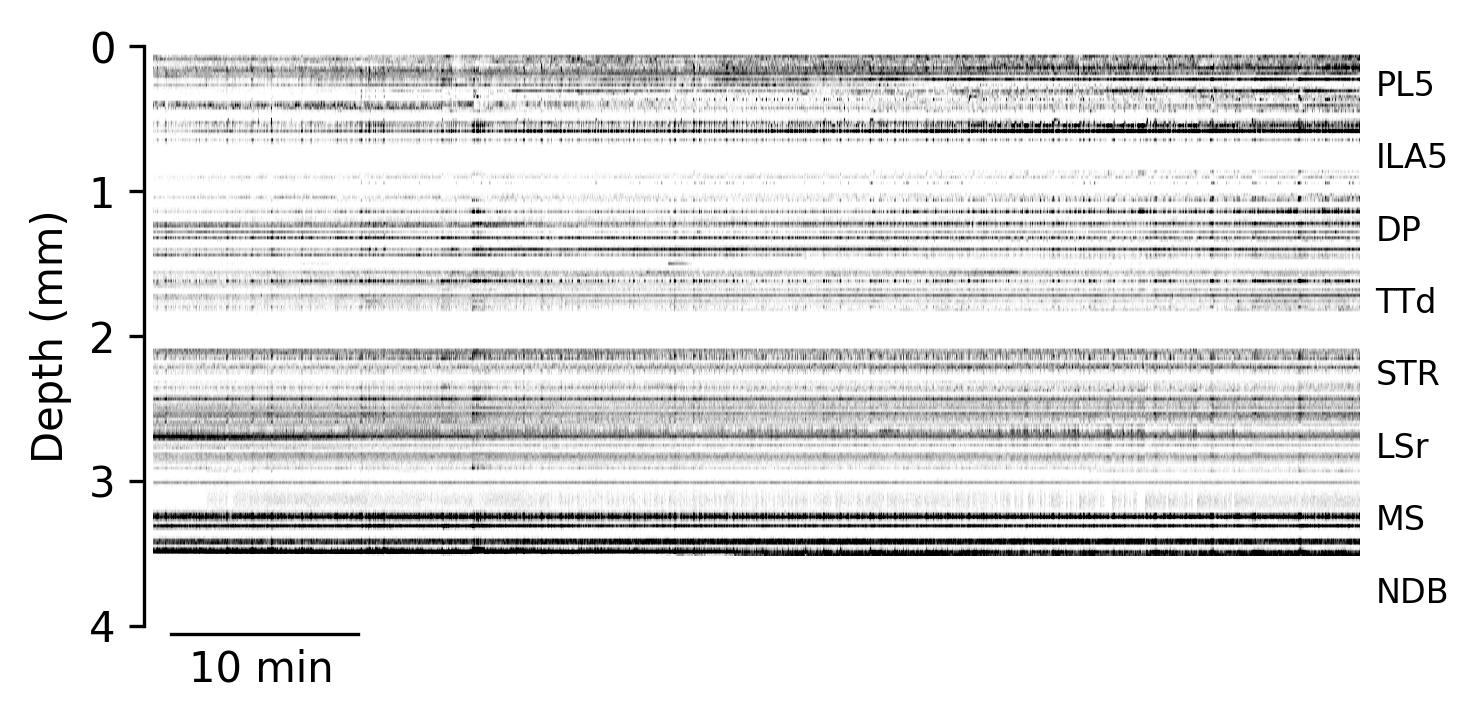

In [2]:
# Modified from plot_example_spike_raster.py
# -*- coding: utf-8 -*-
"""
Created on Mon Mar  6 11:39:45 2023 by Guido Meijer
"""

PID = '540ea29f-610e-47b5-9d2b-cc2425c63ec7'
        
# Load in spikes
sl = SpikeSortingLoader(pid=PID, one=one, atlas=ba)
spikes, clusters, channels = sl.load_spike_sorting()
clusters = sl.merge_clusters(spikes, clusters, channels)

# Only keep IBL good neurons
spikes.times = spikes.times[np.isin(spikes.clusters, clusters.cluster_id[clusters.label == 1])]
spikes.depths = spikes.depths[np.isin(spikes.clusters, clusters.cluster_id[clusters.label == 1])]
spikes.clusters = spikes.clusters[np.isin(spikes.clusters, clusters.cluster_id[clusters.label == 1])]

# Convert to mm
spikes.depths = spikes.depths / 1000

# Get spike raster
iok = ~np.isnan(spikes.depths)
R, times, depths = bincount2D(spikes.times[iok], spikes.depths[iok], xbin=0.01, ybin=0.02, weights=None)
    
# %% Plot figure
f, ax1 = plt.subplots(1, 1, figsize=(5, 2.5), dpi=300)
ax1.imshow(R, aspect='auto', cmap='binary', vmin=0, vmax=np.std(R),
           extent=np.r_[times[[0, -1]], depths[[0, -1]]], origin='upper')
ax1.set(ylim=[0, 4], ylabel='Depth (mm)')
#ax1.set_title('Awake', color=colors['awake'], fontweight='bold')
ax1.set(xticks=[ax1.get_xlim()[0] + 60, ax1.get_xlim()[0] + 660])
ax1.text(ax1.get_xlim()[0] + 350, 4.3, '10 min', ha='center', va='center')
ax1.axes.get_xaxis().set_visible(False)
ax1.invert_yaxis()

for i in np.arange(1, channels['acronym'].shape[0], 50):
    ax1.text(ax1.get_xlim()[-1]+50, channels['axial_um'][channels['acronym'].shape[0] - i] / 1000,
             channels['acronym'][i], fontsize=8)

plt.tight_layout()
sns.despine(trim=True, offset=2)
plt.savefig(join(path_dict['fig_path'], 'example_raster.pdf'))

2500


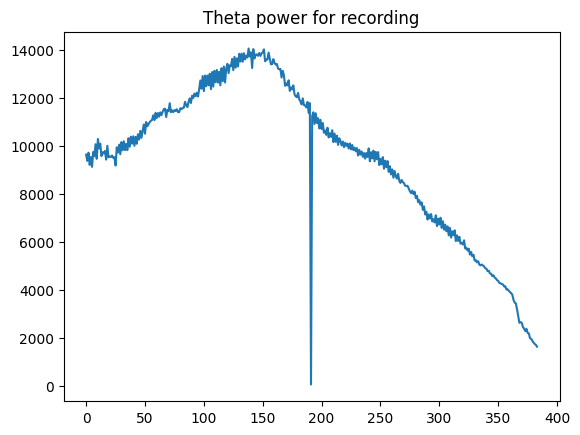

2500
(384,)


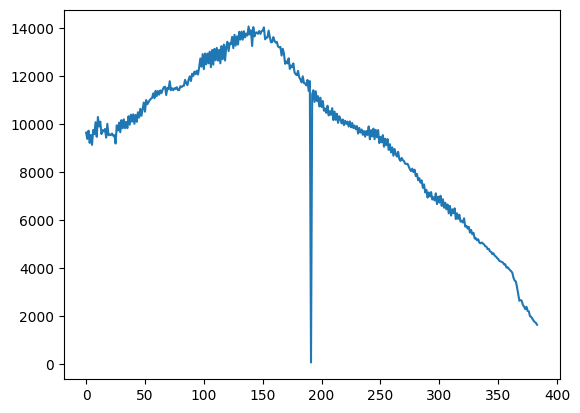

In [3]:
# Modified from lfp.ipynb in /serotonin_remapping
# https://neurostars.org/t/how-can-i-load-the-ibl-lfp-data-spikeglx-does-not-seem-to-be-available-for-python/27499/5

''
file_path = '/home/openlab/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05727/2023-02-01/001/raw_ephys_data/probe00/_spikeglx_ephysData_g0_t0.imec0.lf.cbin'
sr = spikeglx.Reader(file_path)
# access metadata
meta = sr.meta
how_many_seconds = 1000
# access the first 10s of data on all non-sync channels
data = sr[0:int(how_many_seconds * sr.fs), :-sr.nsync]
all_frequencies = []
sampling_rate = int(sr.fs) # assuming sr.fs is your sampling rate
print (sampling_rate)
for i in range(data.shape[1]):
    channel_data = data[:,i]
    ft_channel_data = np.fft.rfft(channel_data)
    freqs = np.fft.rfftfreq(len(channel_data), d=1./sampling_rate)
    # all_frequencies.append((freqs, abs(ft_channel_data)))
    # power_spectrum = np.abs(ft_channel_data)**2
    power_spectrum_channel_data = np.abs(ft_channel_data)**2
    all_frequencies.append(power_spectrum_channel_data)

f0 = np.searchsorted(freqs, 4)
fn = np.searchsorted(freqs, 12)
theta_power = np.row_stack(all_frequencies)[:, f0:fn].sum(axis=1)
plt.plot(theta_power)
plt.title('Theta power for recording')
plt.show()

# Compute Fourier Transform for each channel
all_frequencies = []
sampling_rate = int(sr.fs) # assuming sr.fs is your sampling rate
print (sampling_rate)
for i in range(data.shape[1]):
    channel_data = data[:,i]
    ft_channel_data = np.fft.rfft(channel_data)
    freqs = np.fft.rfftfreq(len(channel_data), d=1./sampling_rate)
    # all_frequencies.append((freqs, abs(ft_channel_data)))
    # power_spectrum = np.abs(ft_channel_data)**2
    power_spectrum_channel_data = np.abs(ft_channel_data)**2
    all_frequencies.append(power_spectrum_channel_data)

f0 = np.searchsorted(freqs, 4)
fn = np.searchsorted(freqs, 12)
theta_power = np.row_stack(all_frequencies)[:, f0:fn].sum(axis=1)
print(theta_power.shape)
# Plot Fourier Transform for each channel
# for i, (freqs, ft) in enumerate(all_frequencies):
#     plt.figure(i)
#     plt.plot(freqs[f0:fn], ft[f0:fn])
#     plt.title(f"Channel {i} Fourier Transform")
#     plt.ylabel("Power")
#     plt.xlabel("Frequency")
    # plt.xlim(0, sampling_rate / 2)
# plt.show()


plt.plot(theta_power)

2500


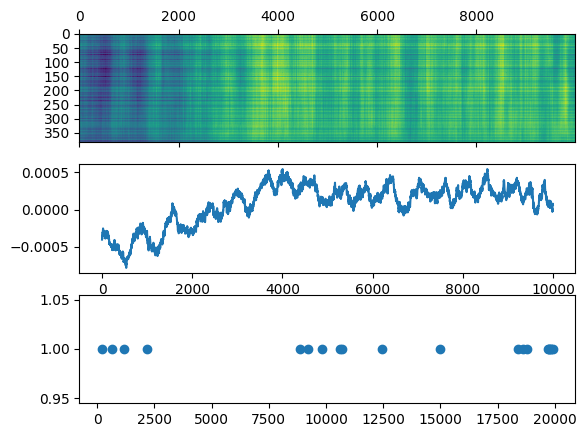

In [4]:
sampling_rate = int(sr.fs) # assuming sr.fs is your sampling rate
print(sampling_rate)
data.shape
t_min = 10000
t_max = 20000
ch = 101

fig, axs = plt.subplots(3)
axs[0].matshow(data[t_min:t_max].T, aspect = 'auto')
axs[1].plot(data[t_min:t_max, ch])
spike_times = spikes['times'][spikes['clusters']==475]
print 
spike_times = spike_times[spike_times<(t_max/sampling_rate)]
axs[2].scatter(spike_times*sampling_rate, np.ones_like(spike_times))

In [5]:
# COHERENCE ANALYSIS USING INSTANTANEOUS FIRING RATE, TIME-RESOLVED

import quantities as pq
from neo import SpikeTrain
from elephant.statistics import instantaneous_rate
from elephant.kernels import GaussianKernel
from scipy.signal import resample
ch = 101
seconds_start = 300
time_window = 600
seconds_start_post = 2700
bottom_freq = 0.3
top_freq = 4

t_min= seconds_start * sampling_rate
t_max = (seconds_start + time_window) * sampling_rate
new_sr = int(len(data)/ 2)
# data = sr[:, :-sr.nsync]


In [26]:
coherences_per_window_per_channel

{'0': {'0': [[]],
  '1': [[]],
  '2': [[]],
  '3': [[0.0074146871279715115]],
  '4': [[]],
  '5': [[]],
  '6': [[]],
  '7': [[]],
  '8': [[]],
  '9': [[]],
  '10': [[]],
  '11': [[0.005846894935484939]],
  '12': [[]],
  '13': [[]],
  '14': [[]],
  '15': [[]],
  '16': [[]],
  '17': [[]],
  '18': [[]],
  '19': [[]],
  '20': [[]],
  '21': [[]],
  '22': [[]],
  '23': [[0.006588139785376172]],
  '24': [[]],
  '25': [[]],
  '26': [[]],
  '27': [[]],
  '28': [[0.029809040170955772]],
  '29': [[0.014257273304514054]],
  '30': [[]],
  '31': [[]],
  '32': [[]],
  '33': [[]],
  '34': [[]],
  '35': [[]],
  '36': [[]],
  '37': [[]],
  '38': [[]],
  '39': [[]],
  '40': [[]],
  '41': [[0.03526332817999289]],
  '42': [[]],
  '43': [[]],
  '44': [[]],
  '45': [[]],
  '46': [[]],
  '47': [[]],
  '48': [[]],
  '49': [[]],
  '50': [[]],
  '51': [[]],
  '52': [[]],
  '53': [[0.016739433967031866]],
  '54': [[]],
  '55': [[]],
  '56': [[]],
  '57': [[]],
  '58': [[]],
  '59': [[]],
  '60': [[]],
  '61': [[]

Session time: 3887.8676 seconds (64.79779333333333 minutes)
Total number of sliding windows:  55
Window number 0
Channel 0
Channel 1
Channel 2
Channel 3
Cluster 38
[3.86794459e-02 8.17461046e-02 8.45127707e-02 ... 5.99957598e+02
 5.99969998e+02 5.99978065e+02]


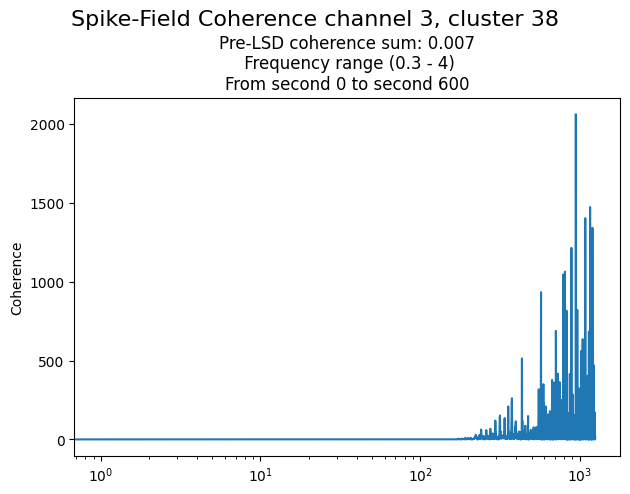

Channel 4
Channel 5
Channel 6
Channel 7
Channel 8
Channel 9
Channel 10
Channel 11
Cluster 70
[5.16127768e-02 7.13461065e-02 8.21794378e-02 ... 5.99788032e+02
 5.99839865e+02 5.99934698e+02]


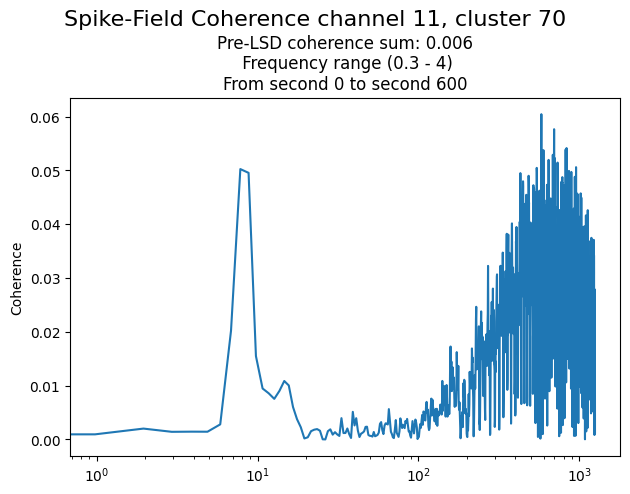

Channel 12
Channel 13
Channel 14
Channel 15
Channel 16
Channel 17
Channel 18
Channel 19
Channel 20
Channel 21
Channel 22
Channel 23
Cluster 122
[1.96127828e-02 5.46461096e-02 9.29127691e-02 ... 5.99805498e+02
 5.99902031e+02 5.99925965e+02]


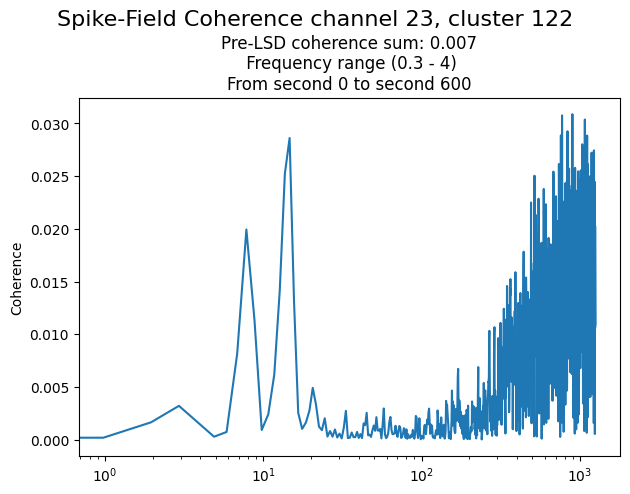

Channel 24
Channel 25
Channel 26
Channel 27
Channel 28
Cluster 151
[4.24461119e-02 5.62127760e-02 6.35127746e-02 ... 5.99945631e+02
 5.99969898e+02 5.99995531e+02]


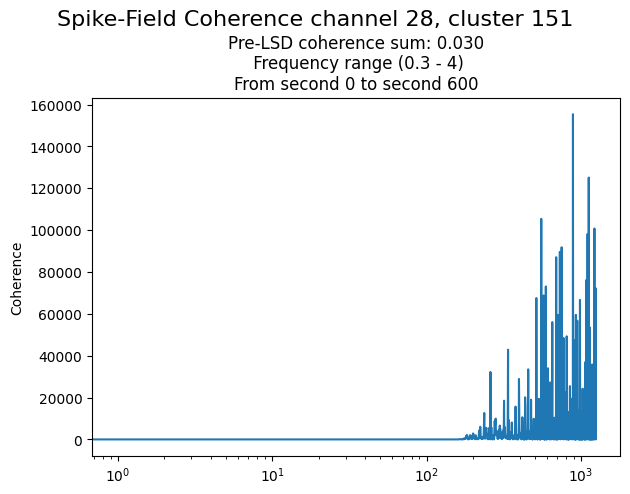

Channel 29
Cluster 152
[1.21812764e-01 3.98112712e-01 1.42597919e+00 2.30574569e+00
 2.55314564e+00 2.92627891e+00 3.09741221e+00 3.39087882e+00
 5.83454503e+00 8.45057788e+00 8.86504447e+00 9.71434431e+00
 9.92754427e+00 1.06777108e+01 1.11024107e+01 1.14774440e+01
 1.16832773e+01 1.19532106e+01 1.22040105e+01 1.43661434e+01
 1.51498433e+01 1.57654765e+01 1.59909765e+01 1.63138431e+01
 1.68611763e+01 1.73224429e+01 1.75464095e+01 1.80287094e+01
 1.91207092e+01 1.92222425e+01 2.27553419e+01 2.30081418e+01
 2.49202415e+01 2.67930078e+01 2.72328744e+01 2.91065740e+01
 2.93150740e+01 3.05264738e+01 3.08259737e+01 3.24995401e+01
 3.27468400e+01 3.31963733e+01 3.40119731e+01 3.51308396e+01
 3.65410393e+01 3.77788724e+01 3.84564056e+01 3.89155722e+01
 3.91853055e+01 3.94030721e+01 3.97206721e+01 3.98483054e+01
 4.02712386e+01 4.06714719e+01 4.11722718e+01 4.14628717e+01
 4.17143717e+01 4.20829383e+01 4.26013049e+01 4.27779715e+01
 4.28329048e+01 4.29543715e+01 4.35122714e+01 4.36216380e+01
 

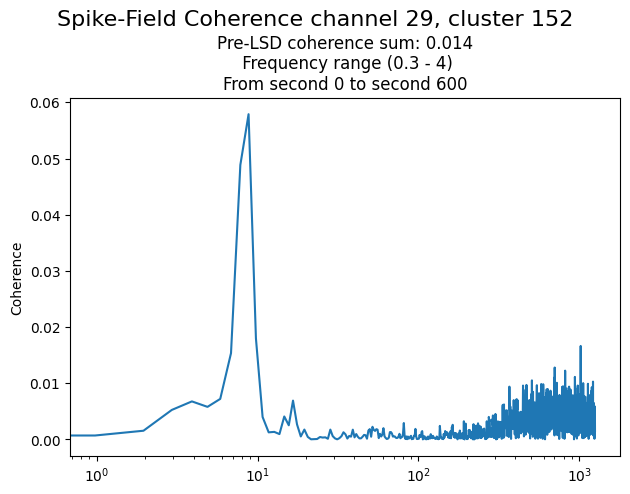

Channel 30
Channel 31
Channel 32
Channel 33
Channel 34
Channel 35
Channel 36
Channel 37
Channel 38
Channel 39
Channel 40
Channel 41
Cluster 218
[149.11951717 166.87644669 169.97854601 ... 599.84886483 599.90509815
 599.97876479]


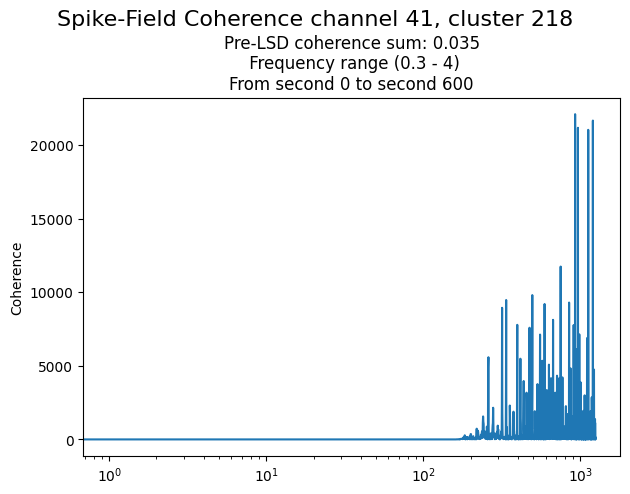

Channel 42
Channel 43
Channel 44
Channel 45
Channel 46
Channel 47
Channel 48
Channel 49
Channel 50
Channel 51
Channel 52
Channel 53
Cluster 262
[1.56779424e-01 2.17446079e-01 3.14712728e-01 ... 5.99272932e+02
 5.99355898e+02 5.99924731e+02]


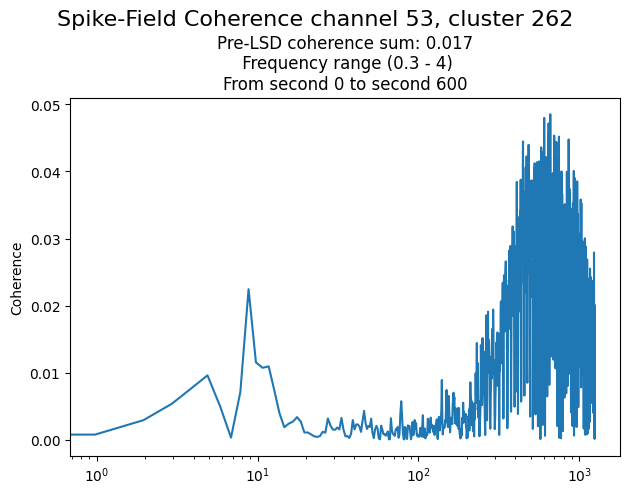

Channel 54
Channel 55
Channel 56
Channel 57
Channel 58
Channel 59
Channel 60
Channel 61
Channel 62
Channel 63
Cluster 312
[7.20127730e-02 1.30646095e-01 3.53679387e-01 ... 5.99515265e+02
 5.99731998e+02 5.99979931e+02]


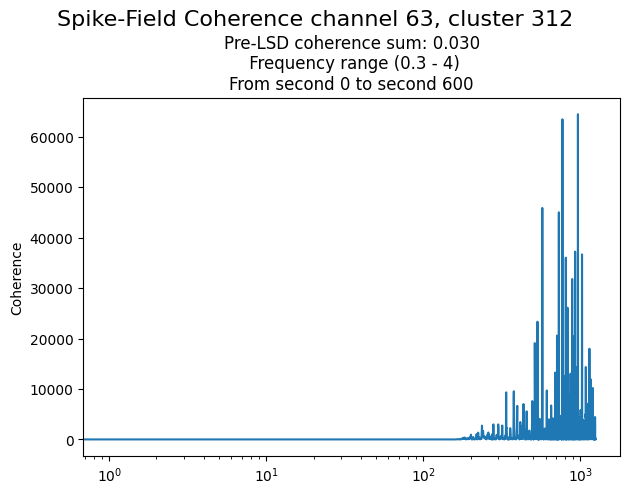

Channel 64
Channel 65
Channel 66
Cluster 323
[8.66127703e-02 2.78212735e-01 4.33512706e-01 ... 5.99550798e+02
 5.99644665e+02 5.99845431e+02]


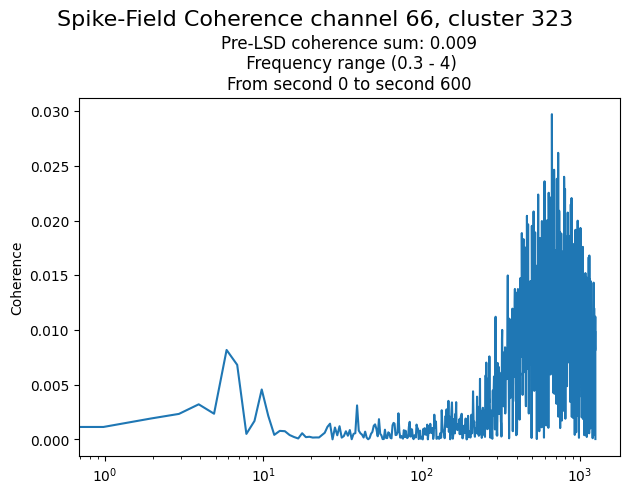

Channel 67
Channel 68
Channel 69
Channel 70
Cluster 341
[3.95112713e-01 4.61679367e-01 8.64979292e-01 ... 5.99719732e+02
 5.99803665e+02 5.99869931e+02]


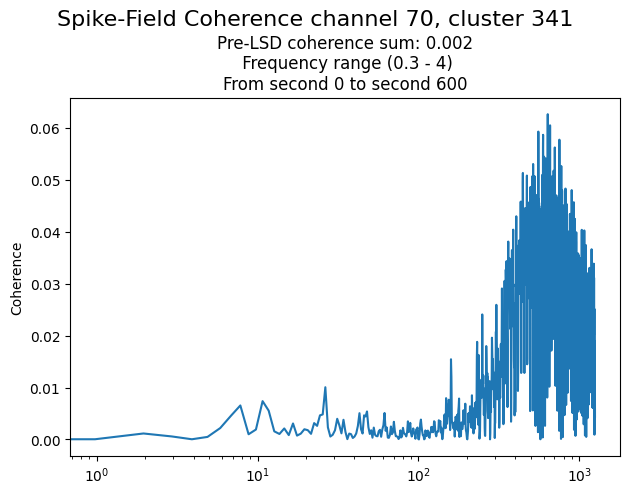

Channel 71
Cluster 348
[ 19.03287591  26.56134118  27.01164109 ... 599.53186491 599.74199819
 599.97663146]


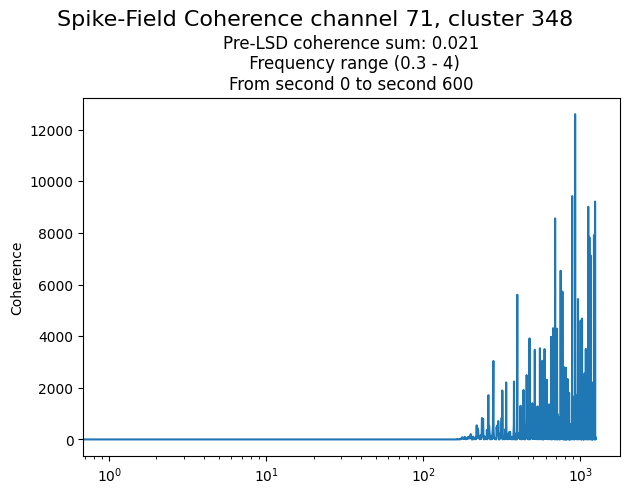

Channel 72
Channel 73
Cluster 351
[1.52379425e-01 2.79746068e-01 4.21179375e-01 ... 5.99314998e+02
 5.99577965e+02 5.99800932e+02]


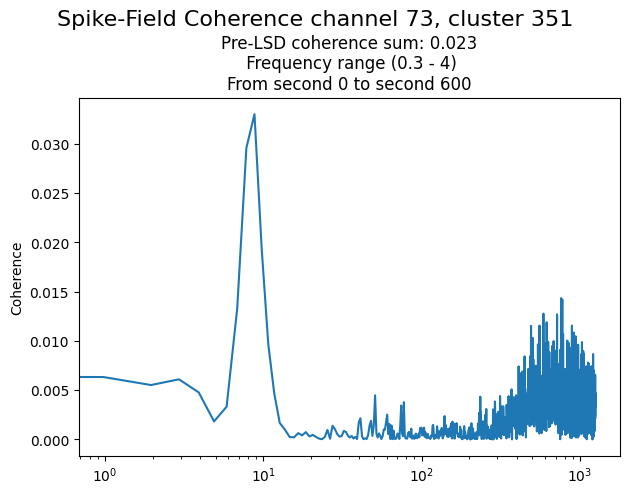

Channel 74
Channel 75
Channel 76
Channel 77
Cluster 365
[8.02794382e-02 4.74212698e-01 7.11112654e-01 ... 5.98835932e+02
 5.99262565e+02 5.99892231e+02]


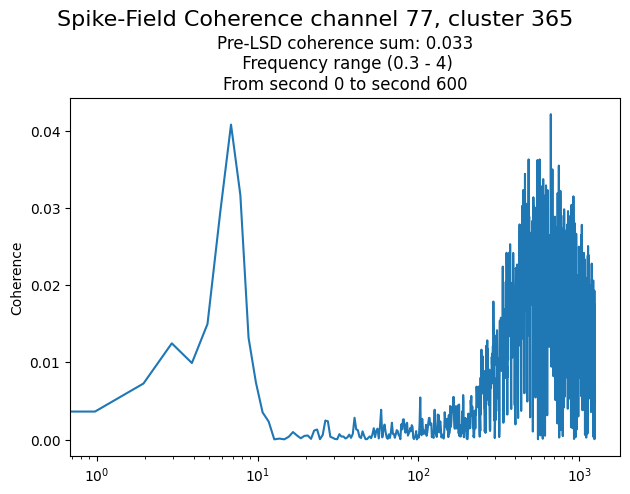

Channel 78
Channel 79
Cluster 1481
[1.85146085e-01 6.36246001e-01 1.17651257e+00 ... 5.99483398e+02
 5.99738632e+02 5.99957631e+02]


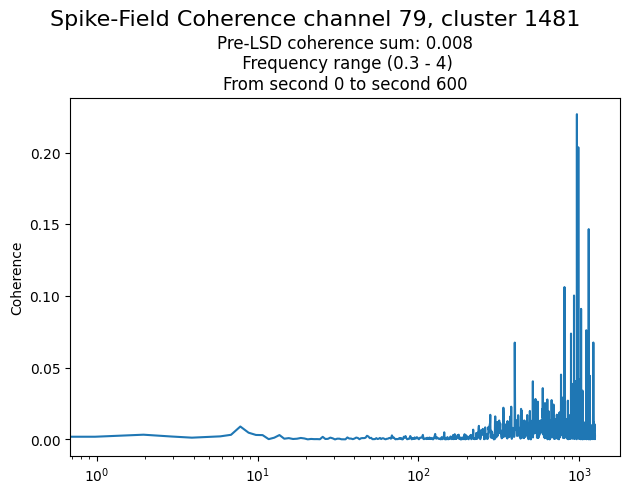

Channel 80
Channel 81
Channel 82
Cluster 1485
[1.29512762e-01 3.72779384e-01 6.81879326e-01 ... 5.99422565e+02
 5.99533065e+02 5.99897331e+02]


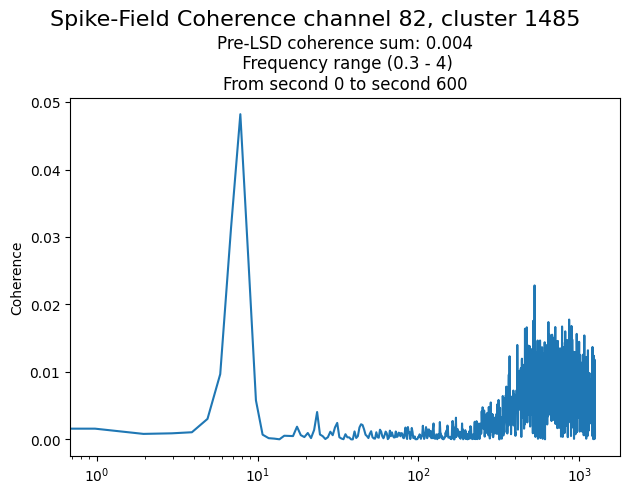

Cluster 1487
[2.37846075e-01 2.78846068e-01 1.30491254e+00 2.00981241e+00
 4.07807869e+00 4.50717861e+00 4.85407855e+00 8.78357782e+00
 1.21067105e+01 1.21576105e+01 1.23026105e+01 1.27467771e+01
 1.32497103e+01 1.33613436e+01 1.34974769e+01 1.37112436e+01
 1.38619435e+01 1.39360435e+01 1.39745102e+01 1.40477102e+01
 1.54778099e+01 1.59204098e+01 1.85392427e+01 1.92700425e+01
 2.15023755e+01 2.21183753e+01 2.28379085e+01 2.28834752e+01
 2.35214417e+01 2.42465083e+01 2.44638082e+01 2.45676082e+01
 2.59103746e+01 2.63127746e+01 2.69060078e+01 3.04157071e+01
 3.11794403e+01 3.12743403e+01 3.17314069e+01 3.20018068e+01
 3.21885735e+01 3.23501401e+01 3.27342734e+01 3.34599399e+01
 3.44204064e+01 3.45079730e+01 3.47413397e+01 3.63988393e+01
 3.87893722e+01 3.89605389e+01 4.15415051e+01 4.27317382e+01
 4.36813380e+01 4.40757712e+01 4.42519712e+01 4.67128707e+01
 4.78589039e+01 4.81611371e+01 5.05285034e+01 5.10921033e+01
 5.12050366e+01 5.13953032e+01 5.19448698e+01 5.20115031e+01
 5.21483364

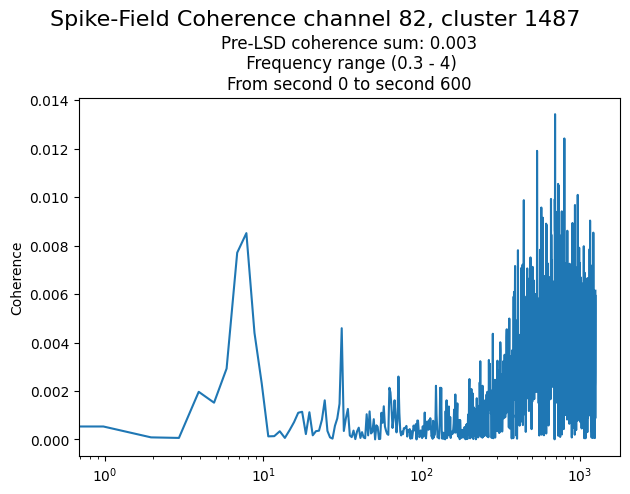

Channel 83
Cluster 400
[1.63479423e-01 1.78946086e-01 4.12446043e-01 ... 5.98987398e+02
 5.99253898e+02 5.99874398e+02]


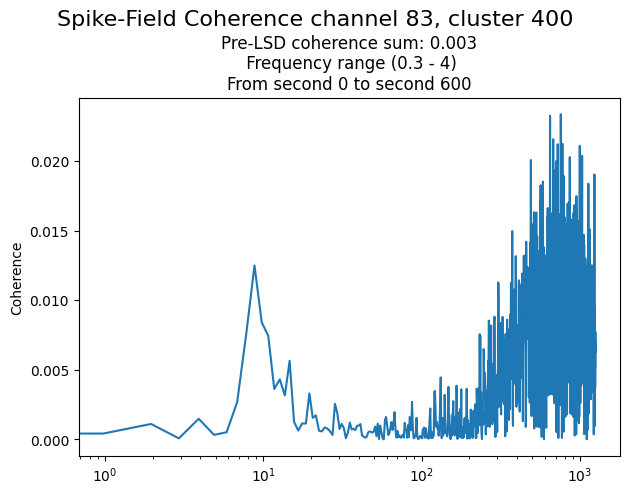

Channel 84
Cluster 402
[1.50512758e-01 1.73212754e-01 1.81379419e-01 ... 5.99696332e+02
 5.99779698e+02 5.99891865e+02]


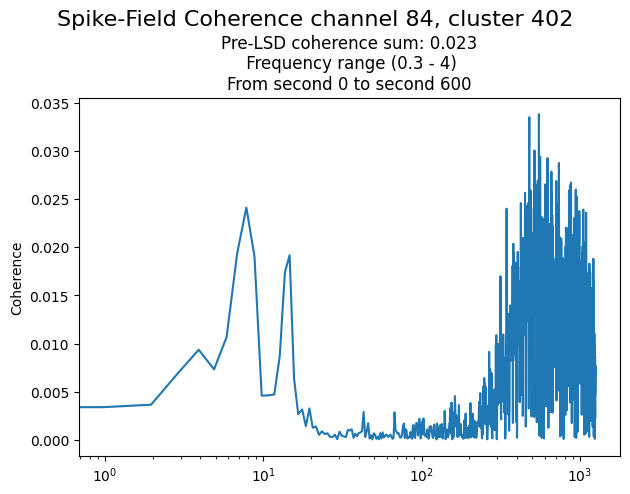

Channel 85
Cluster 409
[4.02794456e-02 1.85112752e-01 2.16979413e-01 ... 5.99797465e+02
 5.99881665e+02 5.99895731e+02]


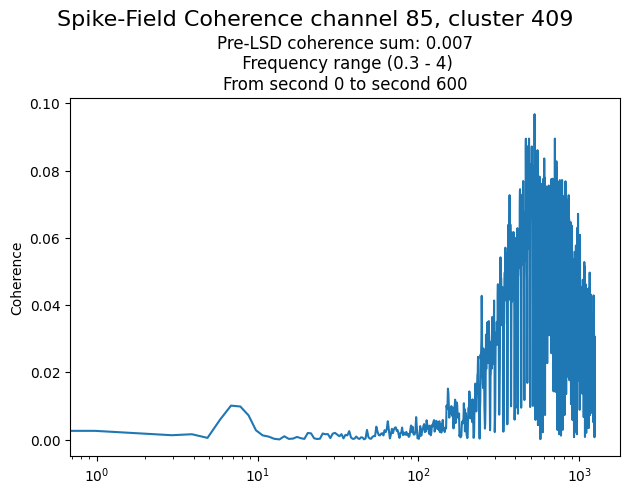

Channel 86
Cluster 1493
[1.67379422e-01 2.97246064e-01 1.13001258e+00 ... 5.98831365e+02
 5.99484998e+02 5.99983898e+02]


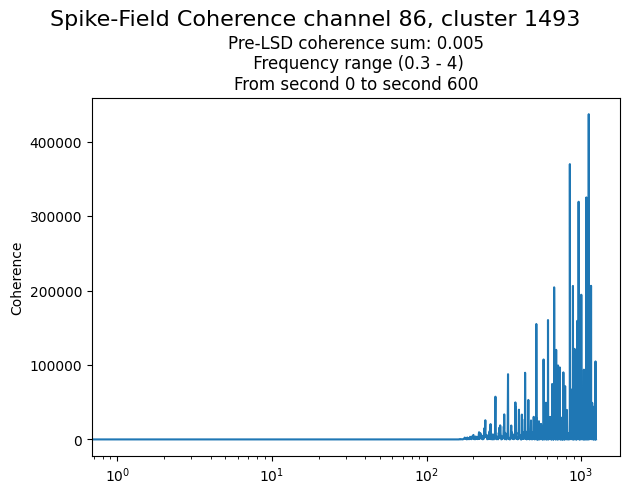

Channel 87
Channel 88
Channel 89
Cluster 427
[7.11461065e-02 1.01612768e-01 1.26312763e-01 ... 5.99820765e+02
 5.99826965e+02 5.99938731e+02]


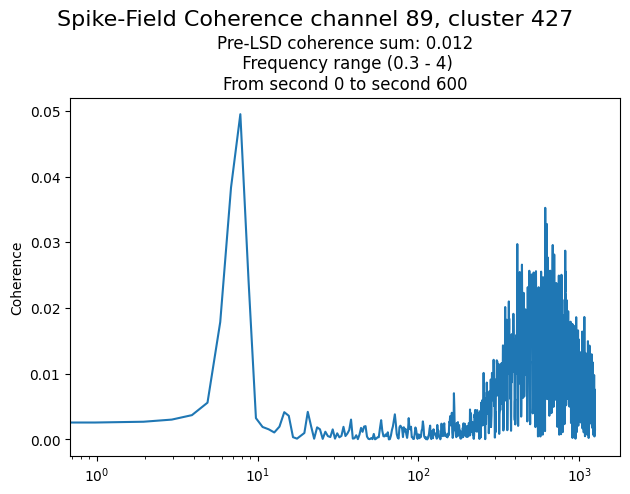

Cluster 1492
[9.07794362e-02 2.44246074e-01 4.45046037e-01 ... 5.99273298e+02
 5.99547465e+02 5.99715532e+02]


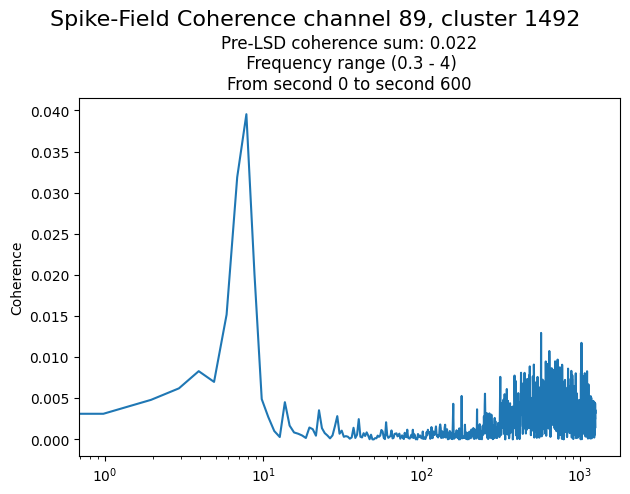

Channel 90
Cluster 1496
[2.72812736e-01 4.72279365e-01 1.90431243e+00 2.01844574e+00
 2.05347907e+00 4.05844536e+00 4.31434532e+00 4.58921193e+00
 5.35927846e+00 5.40144511e+00 6.54711157e+00 7.76681134e+00
 7.81507800e+00 7.99421130e+00 8.06061129e+00 8.20764459e+00
 8.95484445e+00 9.26661106e+00 1.03204775e+01 1.03793109e+01
 1.26992771e+01 1.27574104e+01 1.38527435e+01 1.40826768e+01
 1.40976768e+01 1.54119766e+01 1.59493765e+01 1.80415761e+01
 1.94169758e+01 2.00340424e+01 2.05142756e+01 2.09104089e+01
 2.09672422e+01 2.13118088e+01 2.18886420e+01 2.19171754e+01
 2.25496086e+01 2.26702419e+01 2.28844419e+01 2.31084085e+01
 2.32864418e+01 2.34059418e+01 2.44680082e+01 2.68713078e+01
 2.83042075e+01 2.93062407e+01 2.97996072e+01 3.08599070e+01
 3.09290070e+01 3.23528068e+01 3.28613733e+01 3.33650732e+01
 3.43129397e+01 3.66228726e+01 3.83331390e+01 4.18499383e+01
 4.33242381e+01 4.42193712e+01 4.47587711e+01 4.54056710e+01
 4.63458042e+01 4.67728041e+01 4.83320371e+01 4.83773371e+01


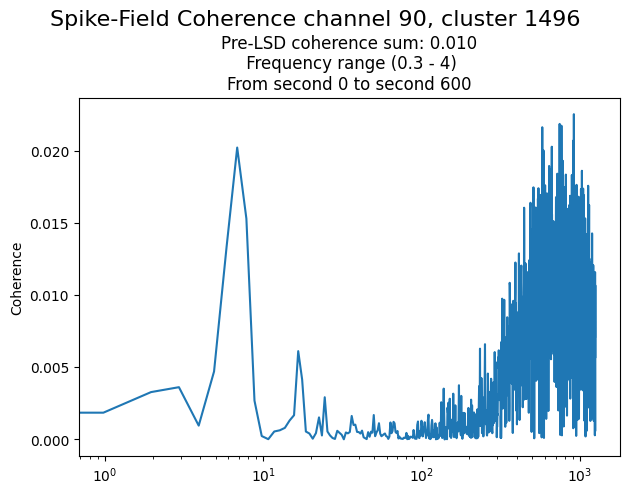

Channel 91
Channel 92
Channel 93
Cluster 437
[1.94146084e-01 6.17046005e-01 6.93712657e-01 ... 5.99256765e+02
 5.99558498e+02 5.99836098e+02]


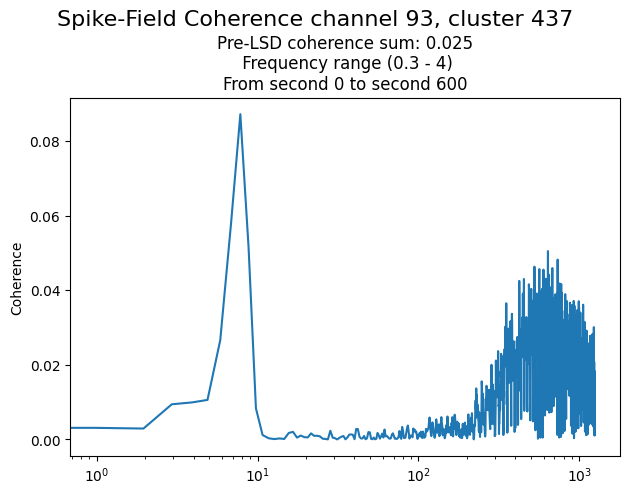

Channel 94
Cluster 445
[9.05461029e-02 2.74312735e-01 3.20946060e-01 ... 5.99500532e+02
 5.99772932e+02 5.99918965e+02]


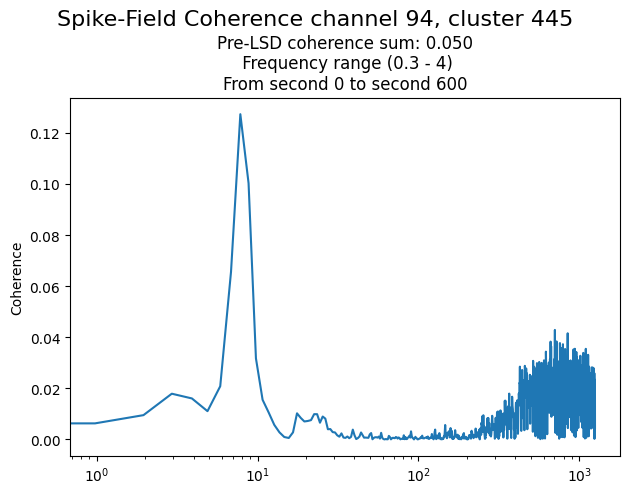

Channel 95
Channel 96
Channel 97
Cluster 461
[3.09212729e-01 3.75779383e-01 6.01012675e-01 ... 5.99895398e+02
 5.99960731e+02 5.99968031e+02]


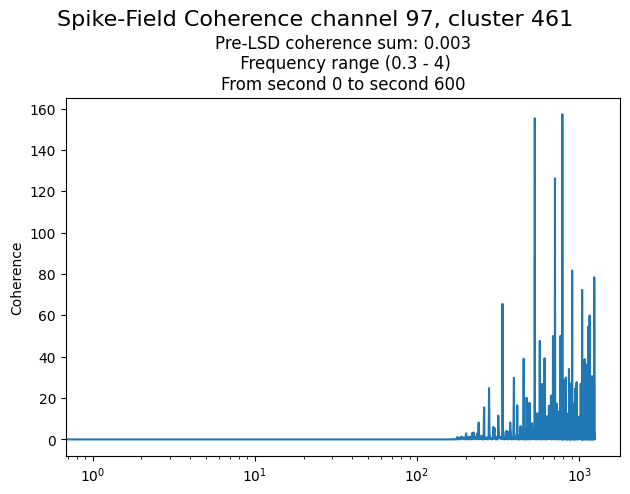

Channel 98
Cluster 454
[1.70812755e-01 1.76912754e-01 2.42546075e-01 ... 5.98324599e+02
 5.98837498e+02 5.99620065e+02]


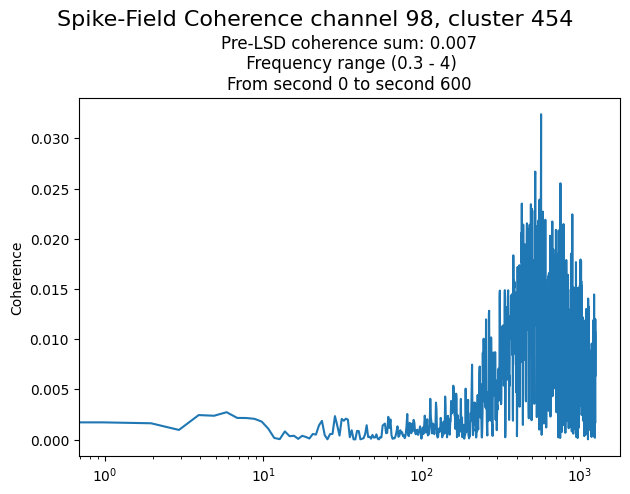

Channel 99
Channel 100
Channel 101
Cluster 475
[8.25461044e-02 2.61012738e-01 4.74646031e-01 8.71812624e-01
 3.54451213e+00 3.68554543e+00 3.92534539e+00 4.24377866e+00
 4.28441199e+00 4.98527853e+00 5.99701167e+00 7.36011142e+00
 7.44107807e+00 7.52141139e+00 7.88604465e+00 7.89351132e+00
 7.90531132e+00 7.92647798e+00 7.93774464e+00 7.96787797e+00
 8.24794458e+00 1.17781773e+01 1.18111773e+01 1.30349770e+01
 1.30625437e+01 1.30949103e+01 1.33001103e+01 1.84279760e+01
 1.85699093e+01 2.02895423e+01 2.17289087e+01 2.18162087e+01
 2.29435085e+01 2.40122417e+01 2.61601413e+01 2.65427745e+01
 2.85720408e+01 3.20778068e+01 3.32755399e+01 3.38360732e+01
 3.40608064e+01 3.40884731e+01 3.55870395e+01 3.87449389e+01
 4.02749386e+01 4.12389718e+01 4.16040717e+01 4.20662716e+01
 4.29392048e+01 4.29555381e+01 4.30298714e+01 4.31271714e+01
 4.31704714e+01 4.38321380e+01 4.40195713e+01 4.40388713e+01
 4.40567712e+01 4.41319379e+01 4.42785712e+01 4.43558045e+01
 4.58412042e+01 4.61263375e+01 4.73752

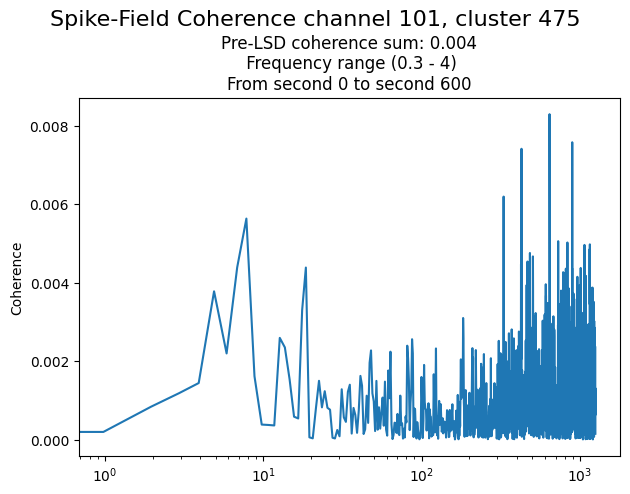

Cluster 477
[  0.61237934   0.74291265   0.90287929 ... 599.80359817 599.85143149
 599.96693146]


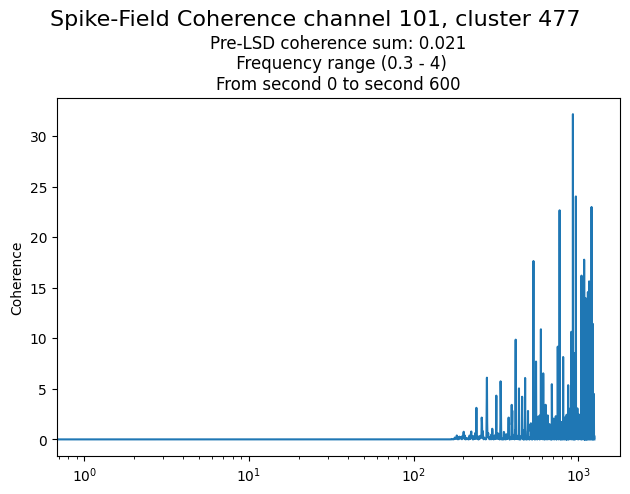

Channel 102
Channel 103
Cluster 482
[1.09546099e-01 1.70279421e-01 2.48612740e-01 ... 5.99376832e+02
 5.99553098e+02 5.99844498e+02]


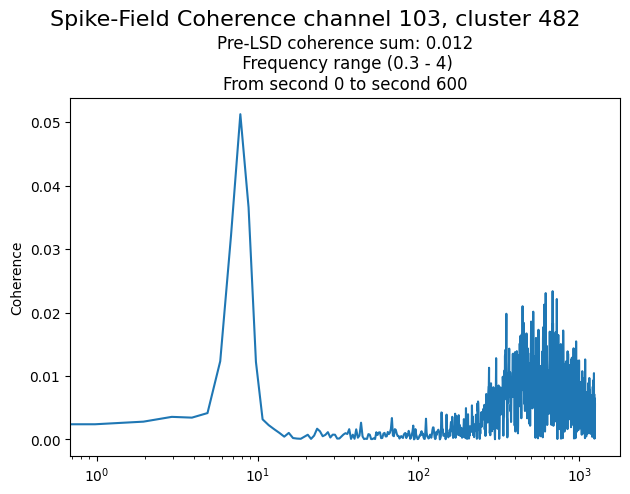

Channel 104
Cluster 480
[2.32646076e-01 2.76212735e-01 4.27912707e-01 ... 5.99599998e+02
 5.99691832e+02 5.99881898e+02]


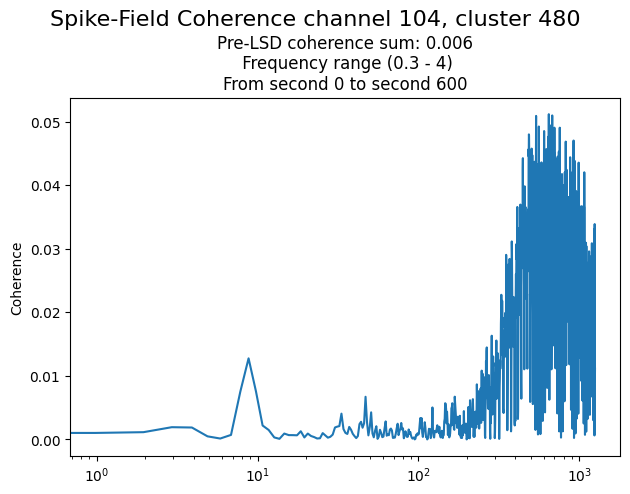

Channel 105
Cluster 1501
[1.66461167e-02 2.01851241e+00 4.14194535e+00 7.65817803e+00
 7.70121135e+00 9.07534443e+00 9.09801109e+00 9.10667776e+00
 1.21430772e+01 1.48675767e+01 1.50567100e+01 1.52776099e+01
 1.73329429e+01 3.38814731e+01 3.56566728e+01 3.61081061e+01
 3.93558388e+01 3.98635054e+01 4.22990049e+01 4.25212382e+01
 4.29505381e+01 4.74017040e+01 4.80033372e+01 4.96650369e+01
 5.27358363e+01 5.46336693e+01 5.46447359e+01 5.46598026e+01
 5.50946025e+01 5.53648025e+01 5.55908357e+01 5.58208024e+01
 5.58274690e+01 5.76185020e+01 5.82443686e+01 5.82574686e+01
 5.83034019e+01 5.83226686e+01 5.83539352e+01 5.84971685e+01
 5.96923016e+01 5.98217683e+01 6.20497012e+01 6.30458677e+01
 6.32850010e+01 6.34280343e+01 6.35475676e+01 6.36384009e+01
 6.86632666e+01 6.99075664e+01 7.22683992e+01 7.84974647e+01
 7.90837646e+01 7.96587645e+01 8.04563310e+01 8.61755966e+01
 8.94480293e+01 9.10869289e+01 9.41016617e+01 9.43113283e+01
 9.65497612e+01 9.68809278e+01 1.00250994e+02 1.01955760e+02

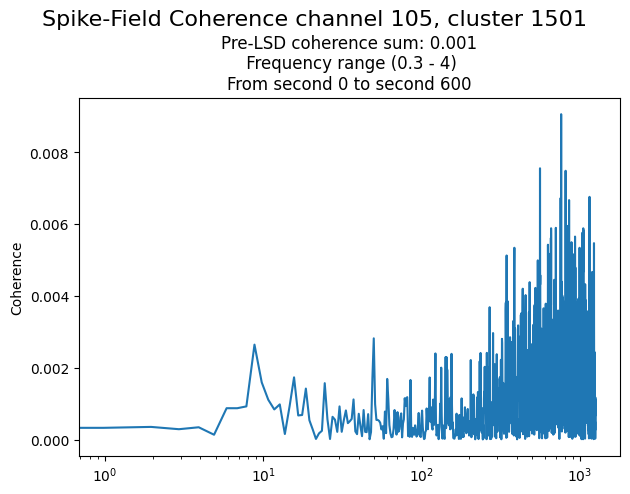

Channel 106
Cluster 497
[  1.57814583   1.90911243   1.99307908   2.01437908   2.02391241
   2.02941241   2.03834574   6.5387449    7.76401134   7.792678
   7.81214467   7.96184464   8.03704462   8.05097795   8.05737795
   8.10384461   8.33574457  10.34037753  10.35361086  14.09241016
  14.11434349  14.12451016  18.64664265  19.37950918  20.79760892
  20.8707089   21.33314215  22.89347519  24.52850822  26.43837453
  31.01537368  31.23627364  37.68080578  38.22393901  46.91857071
  47.11673734  51.4135032   52.60606964  52.90470292  53.07926955
  53.18330287  53.46496948  58.00456863  58.07506862  61.47360131
  62.46416778  62.85406771  62.87533437  63.67593422  65.3377339
  67.31370019  67.34296685  67.42040017  67.43826683  67.45710016
  67.67710012  68.58193328  70.79683286  71.19616612  74.43959883
  74.51749882  75.08853204  77.35169828  77.38766494  77.42436493
  78.92076464  79.04783129  79.07839795  79.08619795  79.09286461
  81.08893089  81.11893089  81.19523087  83.53573042  8

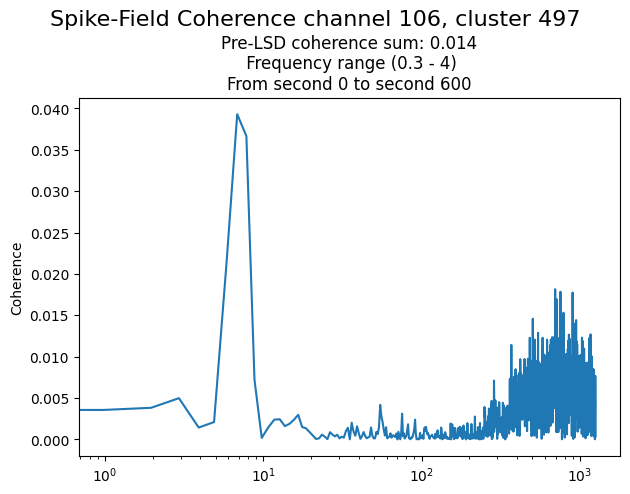

Channel 107
Channel 108
Channel 109
Cluster 495
[1.18779431e-01 5.54446017e-01 8.15879301e-01 ... 5.98708865e+02
 5.98741432e+02 5.99203765e+02]


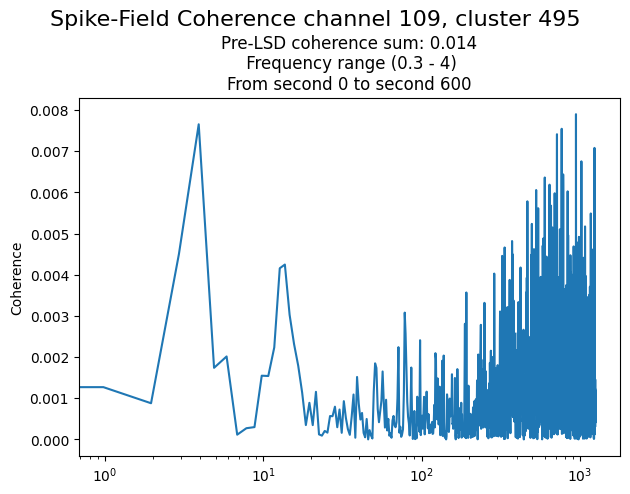

Cluster 505
[1.25546096e-01 1.39912760e-01 1.60417915e+00 1.96201242e+00
 2.03441241e+00 4.13304535e+00 4.34671198e+00 4.65134525e+00
 6.07981165e+00 6.31964494e+00 6.67364488e+00 7.79037800e+00
 7.80351133e+00 8.05834462e+00 8.09491128e+00 9.80027763e+00
 9.80887763e+00 9.82087763e+00 1.03597775e+01 1.23768438e+01
 1.27464104e+01 1.42686435e+01 1.43188768e+01 1.62726764e+01
 1.74912762e+01 1.75053762e+01 1.85493093e+01 1.85566427e+01
 1.98566091e+01 2.01571090e+01 2.07844423e+01 2.07953089e+01
 2.12462422e+01 2.13868755e+01 2.18055087e+01 2.20718087e+01
 2.29104085e+01 2.55054414e+01 2.55230080e+01 2.66570745e+01
 2.66663078e+01 2.89489074e+01 2.96699073e+01 2.99352072e+01
 3.09664070e+01 3.19811068e+01 3.19930735e+01 3.24500734e+01
 3.28634400e+01 3.38423398e+01 3.43427397e+01 3.43892397e+01
 3.46649063e+01 3.54792062e+01 3.59750394e+01 3.68968059e+01
 3.82176057e+01 3.82267057e+01 4.73656040e+01 4.73803373e+01
 4.74014706e+01 4.85628371e+01 4.85770704e+01 4.91240370e+01
 4.91364036e

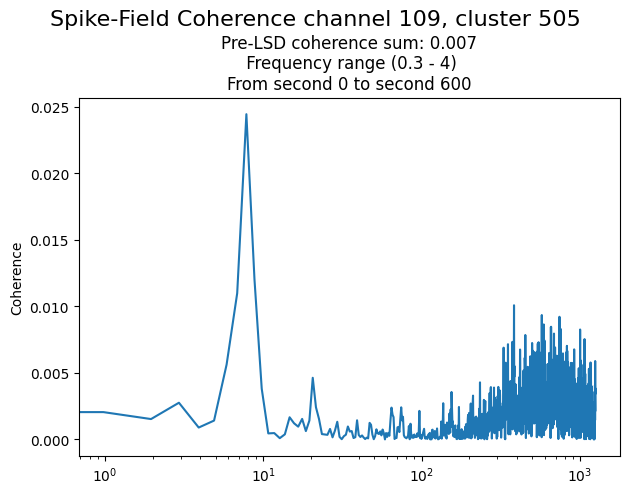

Cluster 1506
[1.94046084e-01 2.19112746e-01 1.61401249e+00 ... 5.98967598e+02
 5.99162398e+02 5.99974365e+02]


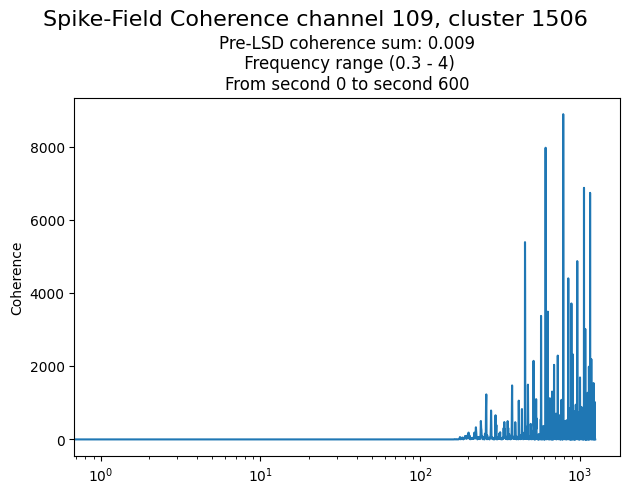

Channel 110
Cluster 516
[7.67127722e-02 1.78079420e-01 1.89546084e-01 ... 5.99792832e+02
 5.99824998e+02 5.99986665e+02]


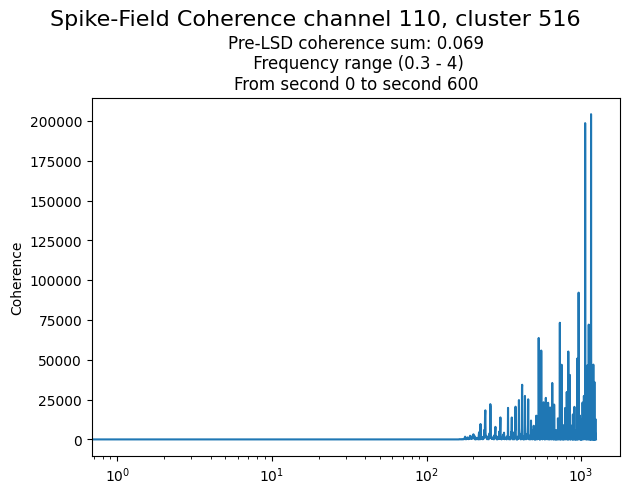

Channel 111
Channel 112
Channel 113
Cluster 519
[1.73312754e-01 1.95079417e-01 2.07579414e-01 ... 5.99128965e+02
 5.99725165e+02 5.99835531e+02]


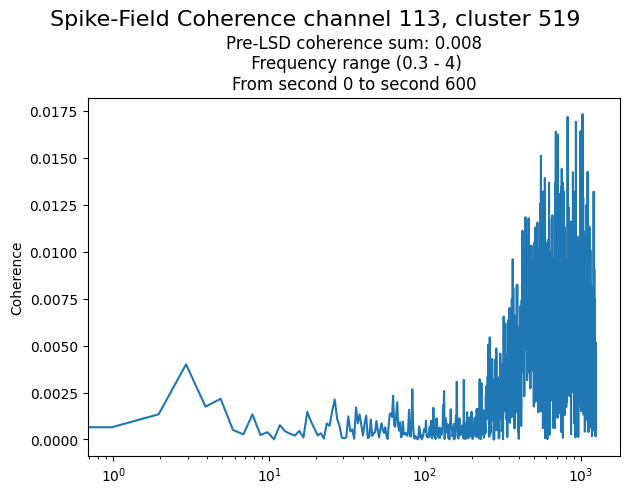

Channel 114
Cluster 523
[2.18712746e-01 2.29367903e+00 4.82081189e+00 5.41094511e+00
 5.65951173e+00 5.91074502e+00 8.22687792e+00 9.11804442e+00
 9.48371102e+00 1.06930775e+01 1.08218774e+01 1.10226441e+01
 1.12996773e+01 1.16509773e+01 1.17099439e+01 1.18735772e+01
 1.32307103e+01 1.35597103e+01 1.45496101e+01 1.48649100e+01
 1.61174765e+01 1.63730431e+01 1.82169761e+01 1.87236760e+01
 1.89554093e+01 1.90992092e+01 2.15296754e+01 2.16307421e+01
 2.18979420e+01 2.44568749e+01 2.51298748e+01 2.63273079e+01
 2.85867075e+01 3.04620071e+01 3.13283403e+01 3.37251398e+01
 3.55775062e+01 3.68297059e+01 3.81755390e+01 3.84920056e+01
 3.86486723e+01 3.88882722e+01 3.90602722e+01 3.95345721e+01
 4.29195715e+01 4.29439048e+01 4.30617381e+01 4.36509047e+01
 4.38361380e+01 4.39320379e+01 4.40738712e+01 4.41606046e+01
 4.51236377e+01 4.95061036e+01 4.95171369e+01 5.21832364e+01
 5.23418697e+01 5.39520027e+01 5.58545357e+01 5.58792357e+01
 5.70730021e+01 5.83267352e+01 5.83690686e+01 5.89529351e+01


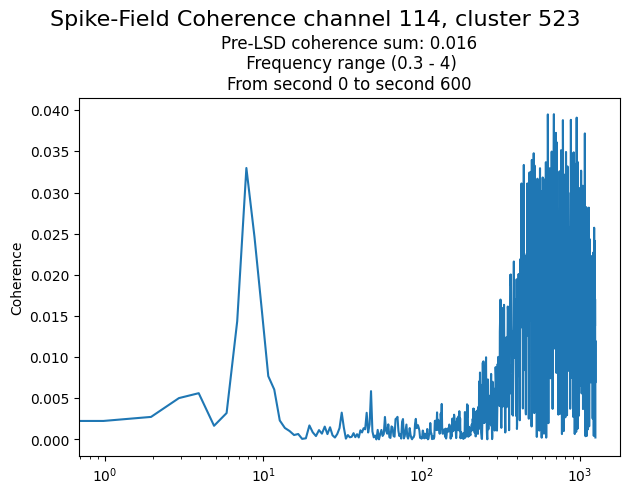

Channel 115
Channel 116
Channel 117
Channel 118
Cluster 538
[1.93079417e-01 4.11712710e-01 5.88879343e-01 ... 5.98916732e+02
 5.98935865e+02 5.99953698e+02]


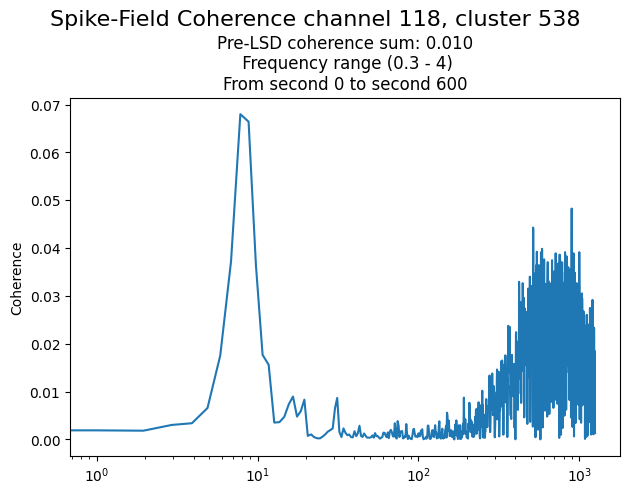

Cluster 541
[  0.68727933   1.57251249   1.74811246   1.75651246   4.18121201
  12.33971049  12.9978437   15.02154332  18.87690927  21.77020873
  25.59670802  31.8231402   34.667373    38.68233892  46.53907078
  47.94450385  55.57610242  59.41916836  67.21923354  67.22556688
  68.46413331  68.4958333   72.47559921  73.583499    79.10083128
  79.10923127  79.11926461  79.17729793  79.21479792  82.56593061
  82.62366393  84.34529693  86.95716308  87.05742973  92.81209528
  93.57416179  94.17396168  96.02916132  98.36929419 109.02115874
 110.41275846 110.42335846 110.43699179 110.45069179 112.64902468
 117.25879043 120.79542305 121.2180563  121.32185628 121.34102294
 121.37815626 121.65622287 121.84265617 121.88762283 123.82522243
 123.97835573 126.44472189 127.65722164 131.95108742 132.70878727
 141.51331878 142.63098521 142.66011854 143.72838498 144.16195155
 144.82495141 146.73625101 159.5050483  160.99781464 161.9567811
 164.65441384 165.59881363 165.61491363 170.03291266 178.33991084

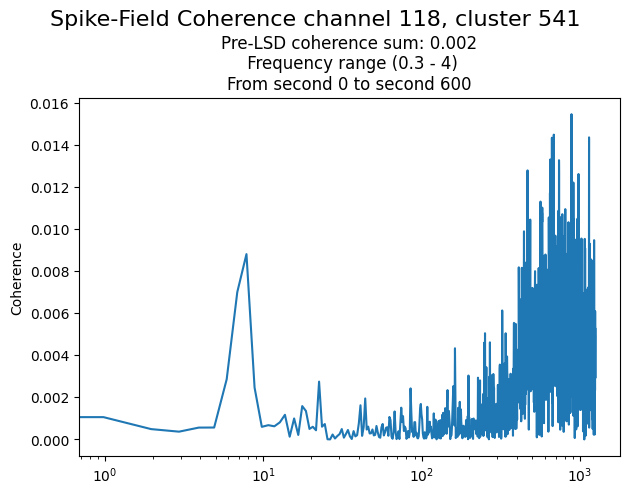

Channel 119
Channel 120
Channel 121
Cluster 545
[4.68779366e-01 1.88761244e+00 2.56491231e+00 ... 5.98265065e+02
 5.98345399e+02 5.99754965e+02]


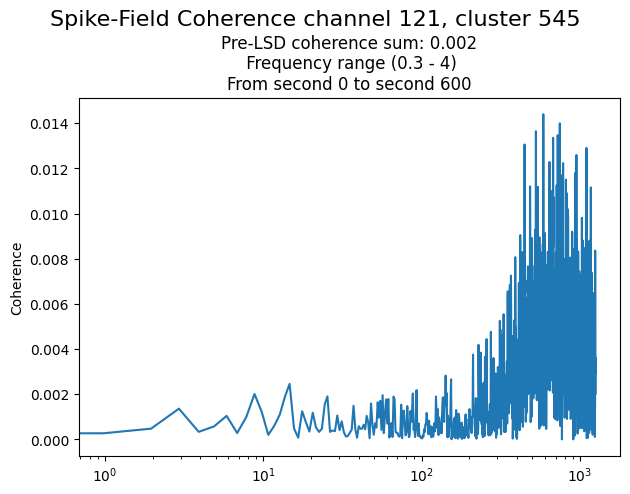

Channel 122
Channel 123
Channel 124
Channel 125
Channel 126
Channel 127
Channel 128
Channel 129
Cluster 574
[5.63846015e-01 7.31779317e-01 1.19534590e+00 ... 5.97803932e+02
 5.97828299e+02 5.98031465e+02]


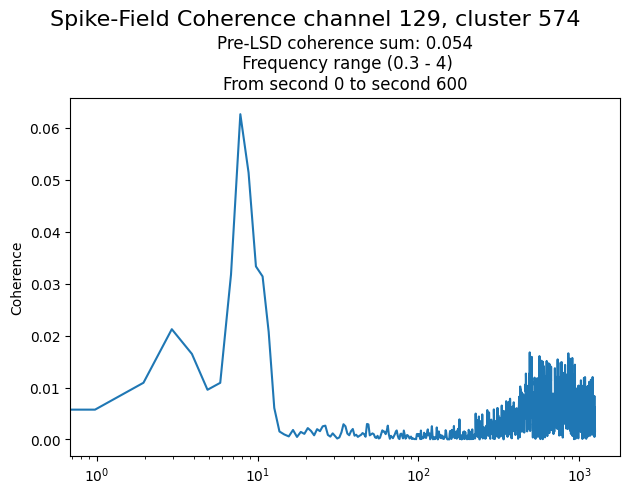

Channel 130
Channel 131
Channel 132
Channel 133
Cluster 588
[8.97461031e-02 2.18646079e-01 2.60079405e-01 ... 5.99414098e+02
 5.99466132e+02 5.99787565e+02]


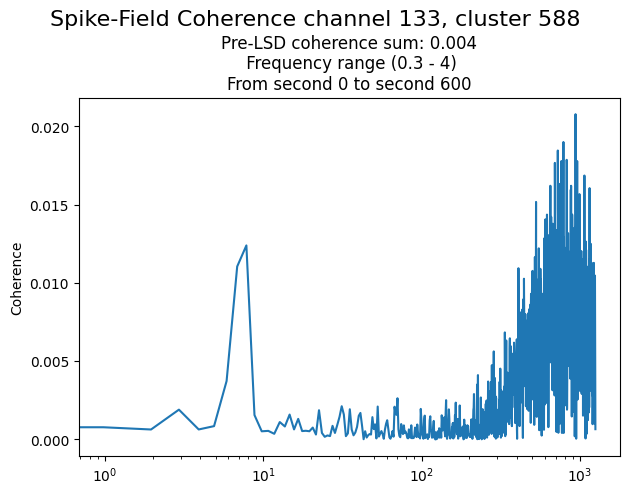

Cluster 592
[  1.93551243   5.4604451    8.05391129   8.06697795   8.09164461
   8.32051124  14.88434335  16.37494307  22.58967525  24.78060817
  27.05570775  33.52957321  33.72763984  42.18013827  50.97260328
  54.97653586  55.96593568  56.70900221  61.64900127  63.33903428
  64.59093404  67.36693352  67.69850012  68.56166662  68.60303328
  69.14549984  73.21286573  74.47663216  78.59013137  80.10236442
  95.58249474  96.03142798  96.44946123  96.4707279   96.51582789
  96.53542788  96.74732784  98.6768608  100.20752717 100.21779383
 102.58389336 102.61346002 109.76435859 115.43625746 117.02819047
 119.2536567  121.38165626 121.54185623 121.56482289 127.52342167
 131.9238541  132.70925393 139.91015245 148.30761734 171.25941239
 172.12467887 173.55571189 173.58454522 175.27481151 180.76814364
 182.9968098  183.58537633 194.09244062 194.22014059 197.09470661
 197.78677312 198.4376063  198.47423963 198.60567293 198.76243956
 198.77363956 198.81453955 198.81817288 198.83163955 198.8422062

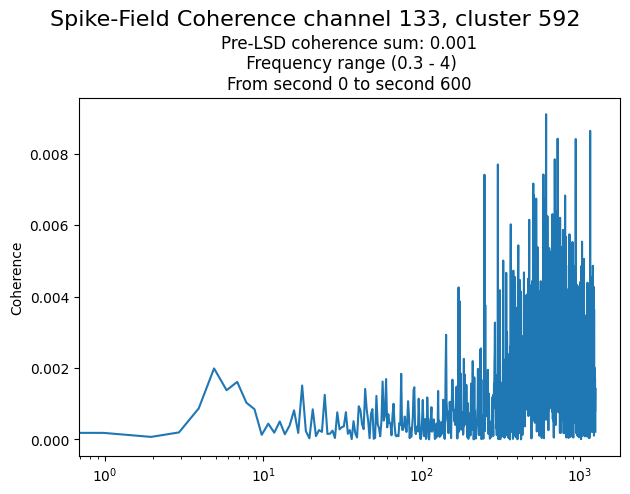

Cluster 602
[  1.51164584   4.46114529   5.35117846   6.11481165   7.50537806
   7.63487803   7.69437802   8.02331129   9.21094441  11.70574394
  12.39487715  12.75377708  13.02984369  13.17914367  13.3614103
  14.56534341  16.57634303  16.82797632  18.75664263  20.26317568
  21.48690879  24.76937484  26.13930792  26.82320779  28.02497424
  28.16417421  28.79604076  29.34867399  31.14777366  31.70630689
  36.84230593  37.36113917  38.96953887  41.56833838  44.17447123
  46.17770418  46.24540417  46.83577073  47.31027064  47.6957039
  48.81503702  48.89573701  48.911537    49.05927031  49.36800358
  49.77573684  50.0150368   50.69347     50.95486995  51.39336987
  52.19550305  54.19213601  54.6082026   54.94840254  55.18940249
  55.26703581  55.64123574  56.5606689   56.67790221  62.3638678
  64.73220068  67.34300019  67.40520017  68.29513334  68.40063332
  68.55339996  69.17679984  69.22593316  69.30419981  69.58429976
  78.08099814  78.2981981   78.51623139  78.74499801  82.22839734
 

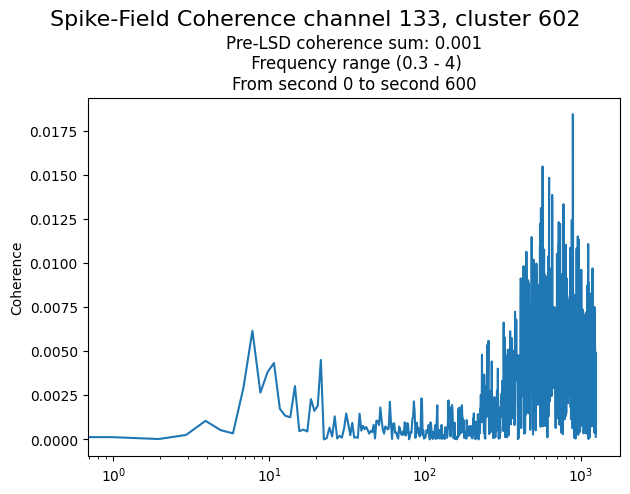

Channel 134
Cluster 598
[  1.49444584   5.18977849   5.37724512   8.05381129   8.09174461
   8.21494459   8.28467791   8.33941123  13.71234357  35.99727276
  53.12636955  53.17160287  53.53713613  62.85556771  63.36420095
  63.59363424  63.62086756  63.65753422  63.78860086  67.34096685
  67.68973345  67.72743345  68.20573336  68.48019997  68.51039996
  68.72283326  71.01533282  73.66526565  76.41519846  76.83909837
  77.08306499  77.17709831  77.28549829  77.36626494  77.39316494
  77.41896493  85.11006344  85.53886336  89.11306266  89.47716259
  89.5906959   89.62286256  89.68549589  90.77036234  92.65966197
  93.17766187  96.41076124  96.48236123  96.72832785 100.43216046
 100.44289379 100.47199378 104.16562638 105.26229282 106.78232585
 109.24852536 109.81262525 109.84325858 109.85965857 110.14115852
 110.2149585  111.17392498 111.19855831 111.2475583  111.42069159
 111.55109157 114.91705756 119.77078993 119.78892326 123.87638908
 124.17402236 124.38358898 126.07792196 126.13862195

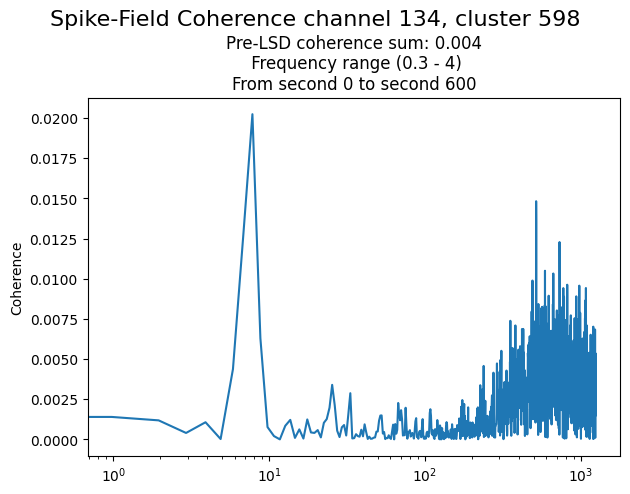

Channel 135
Channel 136
Channel 137
Channel 138
Channel 139
Cluster 618
[  0.89731262   1.06821259   1.21531256 ... 599.95993147 599.9671648
 599.99166479]


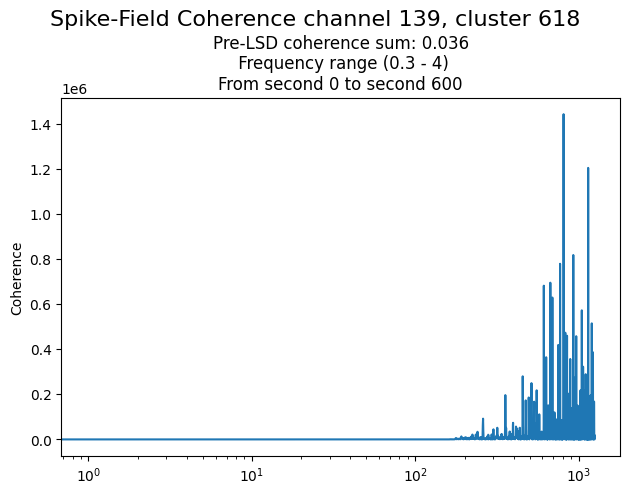

Channel 140
Cluster 622
[2.40246075e-01 1.14347924e+00 5.36654512e+00 7.96207797e+00
 8.09187795e+00 8.30804457e+00 8.32194457e+00 1.35164769e+01
 1.40820102e+01 1.53806766e+01 1.79058428e+01 1.86404427e+01
 1.90104092e+01 2.02296757e+01 2.13396421e+01 2.13568088e+01
 2.13650088e+01 2.41600416e+01 2.51036748e+01 2.81593409e+01
 2.89506407e+01 2.92340740e+01 3.20012735e+01 3.92462055e+01
 3.94183388e+01 4.14981717e+01 4.61976042e+01 4.66582374e+01
 4.89323037e+01 4.94084702e+01 5.25458363e+01 5.33954028e+01
 5.34873695e+01 5.38008028e+01 6.11266680e+01 6.28599344e+01
 6.73385002e+01 6.93213665e+01 7.09994662e+01 7.27748658e+01
 7.44212322e+01 7.68158650e+01 7.74004983e+01 7.77010315e+01
 7.77329315e+01 7.88604313e+01 8.11369309e+01 8.22853640e+01
 8.30100972e+01 8.58008966e+01 8.58461300e+01 8.60294966e+01
 8.96613626e+01 8.96820292e+01 9.08883623e+01 9.23450620e+01
 9.31614619e+01 9.31756952e+01 9.32208619e+01 9.43016283e+01
 9.60367946e+01 9.63421613e+01 9.63612279e+01 9.64343946e+01


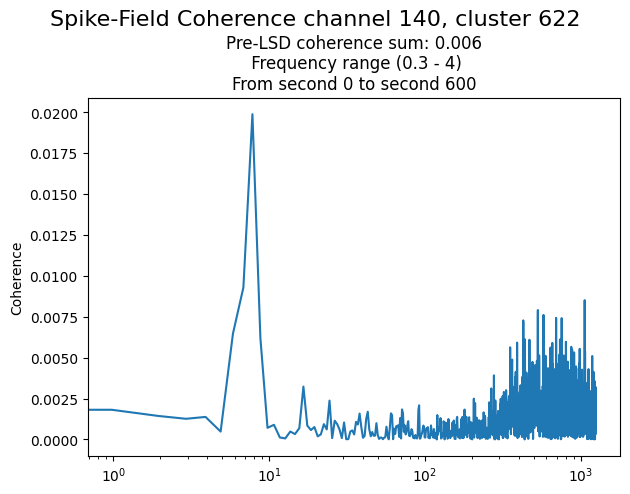

Channel 141
Cluster 624
[1.57794502e-02 2.52612739e-01 3.44812722e-01 ... 5.99695098e+02
 5.99866131e+02 5.99988331e+02]


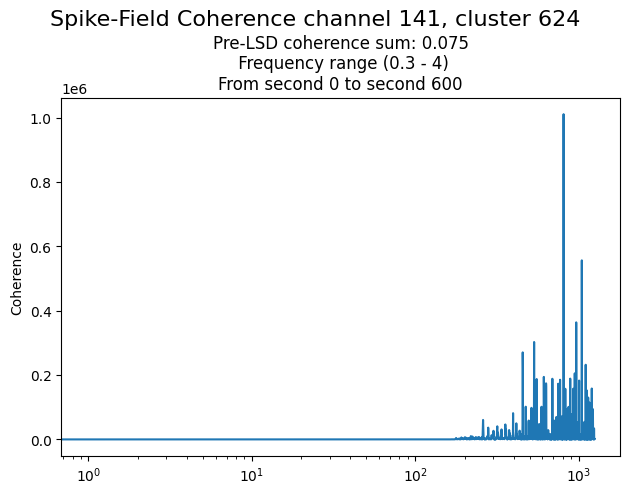

Channel 142
Cluster 633
[1.74479421e-01 5.18412690e-01 1.48497918e+00 ... 5.99288732e+02
 5.99516132e+02 5.99624665e+02]


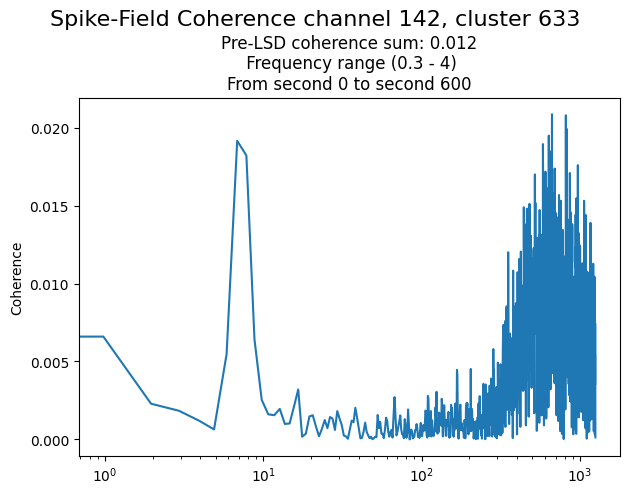

Channel 143
Channel 144
Channel 145
Cluster 646
[6.73127739e-02 1.77512753e-01 1.90446084e-01 ... 5.99214498e+02
 5.99891031e+02 5.99920165e+02]


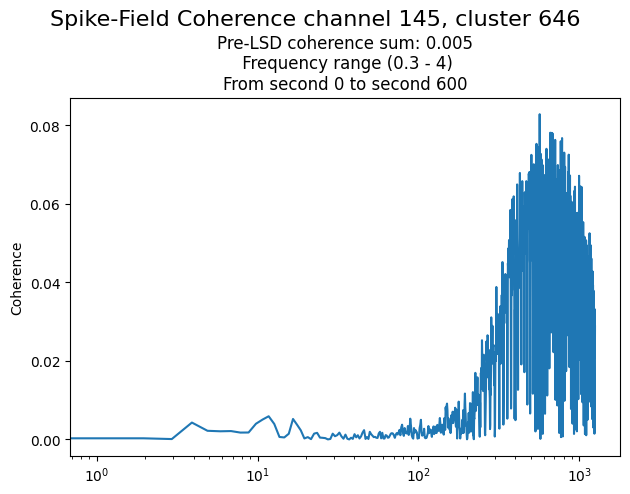

Channel 146
Channel 147
Channel 148
Channel 149
Channel 150
Channel 151
Channel 152
Channel 153
Channel 154
Channel 155
Channel 156
Channel 157
Channel 158
Channel 159
Channel 160
Channel 161
Channel 162
Channel 163
Channel 164
Channel 165
Channel 166
Channel 167
Channel 168
Channel 169
Channel 170
Channel 171
Channel 172
Cluster 749
[  0.74934598   0.82431263   0.93221261 ... 597.61393208 597.68743206
 597.83473202]


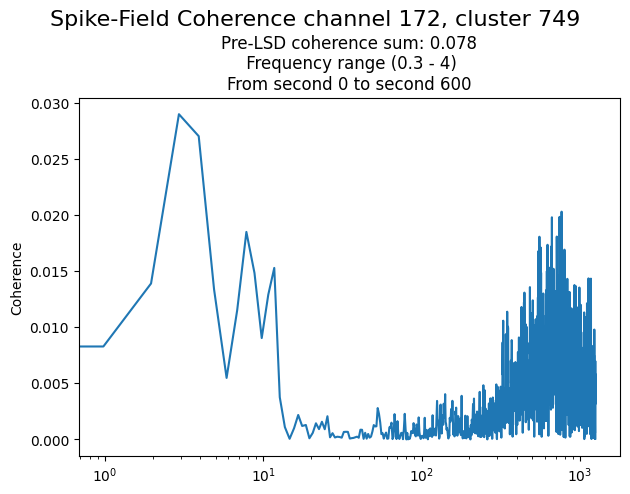

Channel 173
Cluster 751
[  2.14787905   3.33871217   8.37214456   9.12704442  21.73070874
  22.83820854  23.88447501  26.67737449  27.32614103  28.22120753
  38.98303887  65.78913382  67.54370015  81.33576418  86.8540631
  90.84462899  96.42716124  96.57392788 108.73962546 112.43019139
 113.13179125 113.8861911  114.47279098 119.35339001 121.12755632
 127.78928828 138.41551943 138.56158607 147.19745091 147.49418418
 151.50931666 156.78561554 158.27511523 159.67611493 162.84124757
 163.04598086 163.50544743 163.92348067 164.31918058 165.17601373
 165.19131372 166.10008019 171.46641235 172.00674556 172.20191219
 172.37327882 180.09734379 189.28407504 191.71647449 191.72094116
 191.73504115 192.412541   196.59124005 199.75723934 215.5701023
 219.51790138 224.32310022 228.98696576 230.92203196 245.72042834
 249.84549398 256.01159244 258.5810918  258.78822509 266.99118966
 279.0488199  280.25501959 283.73101868 284.23801855 285.15171831
 286.58275127 295.99031546 296.45074867 300.43461429 3

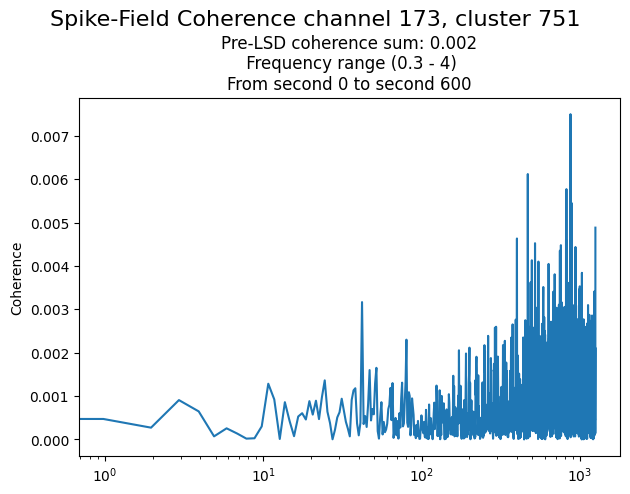

Channel 174
Channel 175
Channel 176
Channel 177
Cluster 763
[1.18612764e-01 8.65745959e-01 1.16811257e+00 ... 5.99522098e+02
 5.99689632e+02 5.99797732e+02]


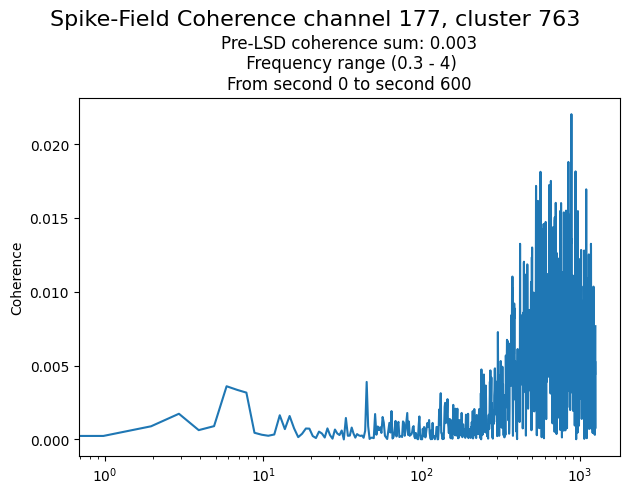

Channel 178
Channel 179
Channel 180
Channel 181
Cluster 785
[3.23794471e-02 1.02579434e-01 2.00846082e-01 ... 5.99761098e+02
 5.99884465e+02 5.99991298e+02]


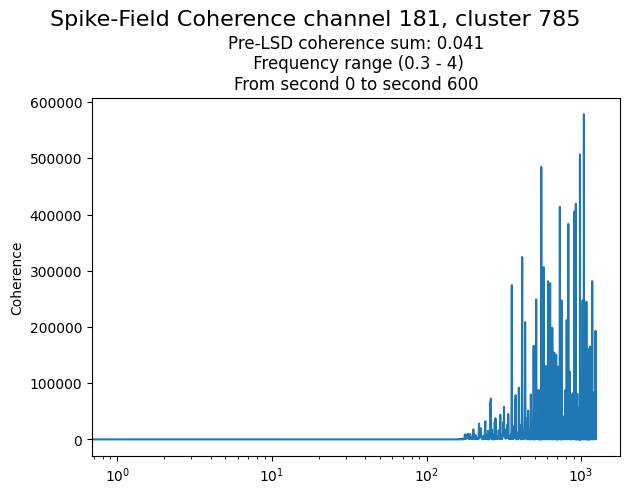

Channel 182
Cluster 786
[ 15.85804317  39.74400539  41.31437176  57.00430215  59.9488016
  98.43386085 117.32332375 132.41258733 144.98098471 157.47624873
 157.51541539 157.53898205 157.65291536 157.71441535 157.86464865
 158.10918193 180.46354371 190.62217474 190.79420803 200.95200573
 203.74987174 218.38316831 222.74786727 230.81896532 245.72086167
 284.32678519 301.94821389 302.69141369 307.70961234 312.40264441
 318.80887603 322.00997516 331.28897262 343.8676025  344.43670234
 345.4232354  345.70380199 346.13996853 346.33150181 346.5217351
 347.54020148 347.90863471 348.37346791 349.00343441 349.05363439
 349.06593439 349.21456768 349.24056767 349.41460096 349.46233428
 349.61816757 349.65683422 349.90363416 351.06623383 353.86333306
 356.17569908 366.03109633 382.11212514 396.11605451 399.26488695
 400.72411987 402.30795276 406.131785   412.8258831  418.77081475
 420.6836142  421.85061387 422.59311366 427.77351218 427.91964548
 430.01321155 430.70537802 431.67551108 431.96107766 4

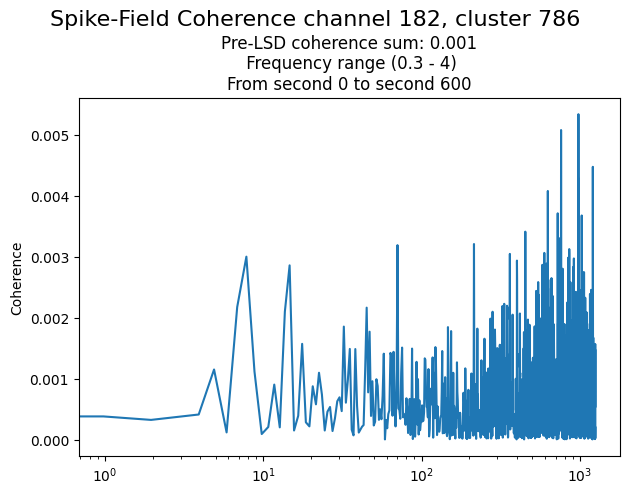

Channel 183
Channel 184
Channel 185
Cluster 792
[ 14.88027668  15.3446766   41.51983839  42.46603821  42.50067154
  42.81273815  42.91523813  53.25956952  58.38100189  72.75756582
  72.81383248  73.2285324   81.36973084  82.73753057  96.38016125
  96.76646117  97.54942769  99.47896064  99.51619397 109.83125858
 111.38992493 116.89622383 116.91832383 126.20108861 131.70532081
 136.47378649 139.26218592 142.80501851 143.93731827 149.80411702
 150.04888364 150.11458362 150.6800835  151.11788341 151.27551671
 155.13724923 157.53021539 164.02268065 165.3202137  169.81404604
 173.28037862 176.22951131 182.48124325 189.20674173 191.90920778
 193.06627419 197.77923978 201.40760562 201.62647223 208.08667072
 208.12793738 208.73623724 208.77227056 215.37706901 215.60106896
 222.62460063 228.78973247 232.9793648  242.29389586 243.17836231
 245.04116184 249.39102743 250.41769384 255.95915912 258.43799184
 258.71485844 258.7471251  259.28505829 259.43302492 260.64719128
 260.69615794 261.01122452 2

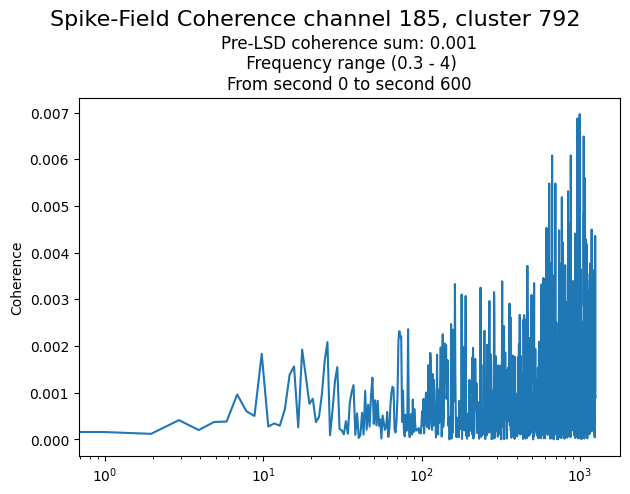

Channel 186
Channel 187
Channel 188
Cluster 809
[1.03846100e-01 2.24879411e-01 4.16112709e-01 ... 5.99577132e+02
 5.99768298e+02 5.99995865e+02]


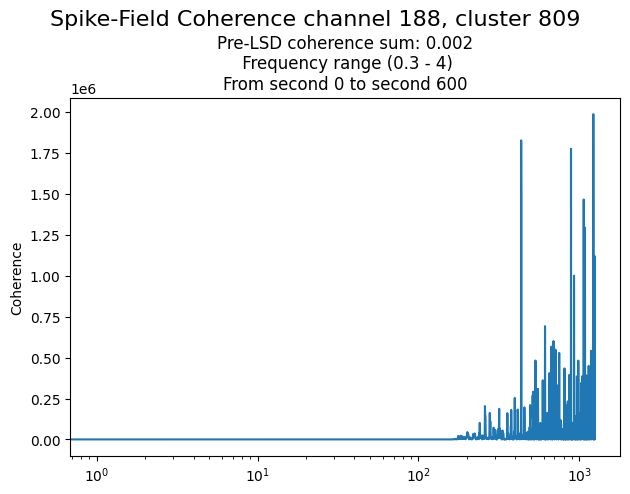

Channel 189
Channel 190
Channel 191
Channel 192
Cluster 823
[4.26379374e-01 7.70379310e-01 7.85645974e-01 ... 5.99701732e+02
 5.99944731e+02 5.99995131e+02]


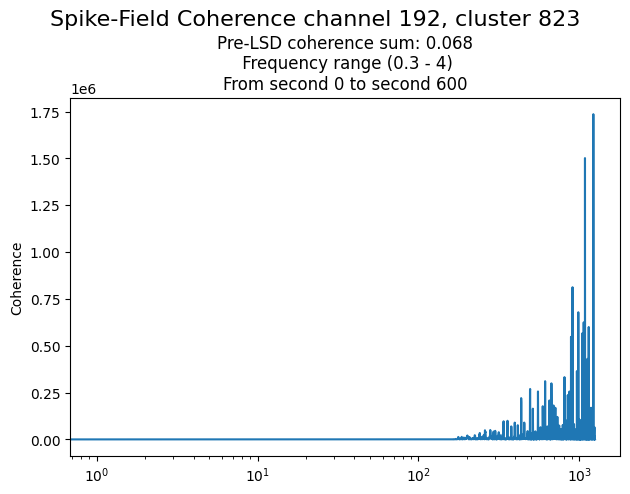

Channel 193
Cluster 828
[  1.22751256   2.01434574   2.02344574   2.03371241   7.10907813
   7.79511134   8.07434462   8.91514446  11.97614389  14.09067683
  14.86391002  15.19187663  17.21474292  35.66460615  38.77580557
  40.27577196  43.20623808  43.97097126  54.9419692   72.72909916
  75.50079863  77.39106494  81.18186421  90.26769577  90.71996235
  96.56716121 104.17192638 105.32115948 107.12439245 109.87675857
 116.89625717 126.0913553  126.43818856 156.64001557 171.17377908
 172.02831223 172.70394541 180.16291044 181.93277671 185.12217599
 195.74834024 199.89057264 203.50200513 208.7537039  208.77113723
 208.8923372  212.36660305 212.38510305 215.82546891 225.92563317
 228.80329914 231.83183174 231.83996507 231.85746507 237.66056366
 238.85366338 238.99433001 240.25659637 240.2696297  242.1436959
 257.31815878 260.80699124 265.43725672 265.46192338 265.88048994
 269.97882223 271.72125511 280.74671947 282.97955221 282.99018554
 286.0556514  286.42075131 295.79928218 302.26828047 

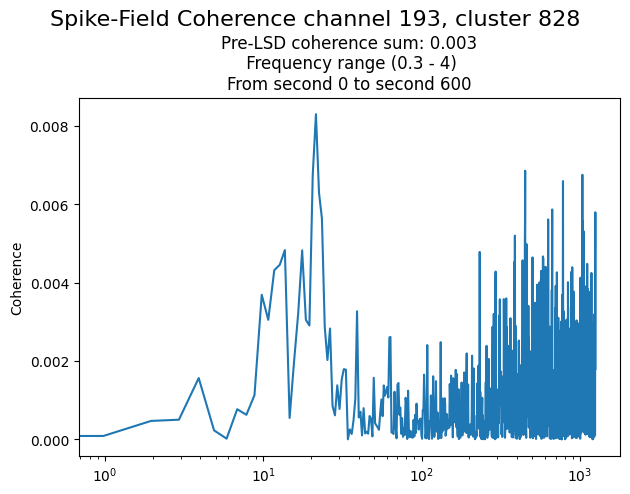

Channel 194
Channel 195
Channel 196
Channel 197
Cluster 842
[  2.92371224   6.69027821   7.66557803   9.35781104  10.39541085
  10.63414414  10.82697744  26.6126745   29.71377392  31.07917367
  36.50577266  37.00277257  38.02940571  38.31567232  39.05867219
  49.8251035   53.18270287  53.33693617  54.34120265  55.42420245
  56.25546896  56.49516891  56.73293553  57.88933532  58.34393523
  60.39676818  63.17423432  64.82286733  65.06463395  65.42476722
  68.26513334  69.83499971  71.18089945  74.29673219  74.66946546
  77.49323158  84.33306359  84.74829685  85.25119675  89.17229599
  89.74262921  90.6552957   90.9590623   93.43892849  93.84092841
  94.00472838  96.71586118 107.14232578 109.14212538 109.43082533
 111.18685831 114.28472436 114.46962432 117.20215711 122.3374894
 122.68012266 122.99478927 126.96838845 127.88762159 131.97678742
 132.10902072 132.28165402 134.88865349 135.83205329 136.82241976
 137.31821965 139.08498596 153.6966162  154.14304944 156.182749
 156.80524887 156.9

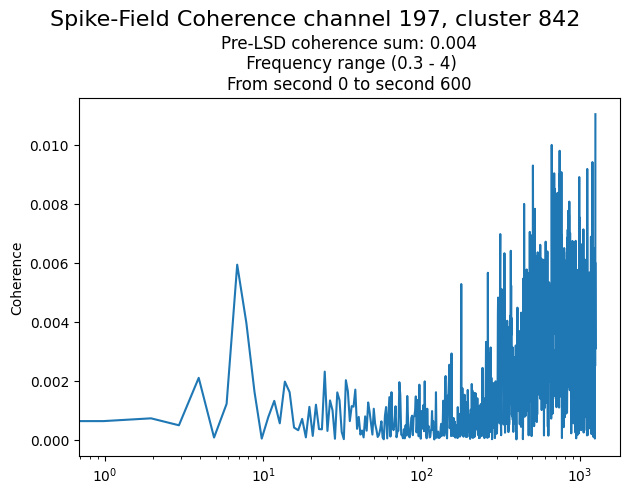

Cluster 843
[  0.73894598   1.48227918   4.248712     4.85684522   4.87401188
   6.25881162   6.44977825   7.12694479   7.27781143   7.6369447
  14.06961017  14.88914335  23.30977511  23.54314174  24.09217497
  24.32324159  25.1812081   27.29000771  27.71104096  28.82300742
  29.13120737  32.10520681  32.3707401   32.66687337  34.27200641
  34.46747304  35.45403952  35.68350615  36.42690601  36.6628393
  36.85223926  37.64347245  38.82910556  38.84463889  39.08643885
  42.57617153  43.4380047   49.93197015  56.20166897  56.69090221
  59.09456842  59.53646834  66.40650037  68.13160004  71.40129941
  71.62759937  71.806466    72.11966594  72.60416585  72.78613248
  76.83569838  77.81759819  77.89013151  78.09849813  78.2757981
  78.73183135  79.44869788  79.55223119  80.31116438  81.40016417
  82.28053066  82.79109723  85.90712995  86.49152984  87.34456301
  87.47646298  90.89192898  91.52502886  92.06966209  92.45399535
  92.85736193  92.99049524  94.98262819  95.75186137  96.8080945
  

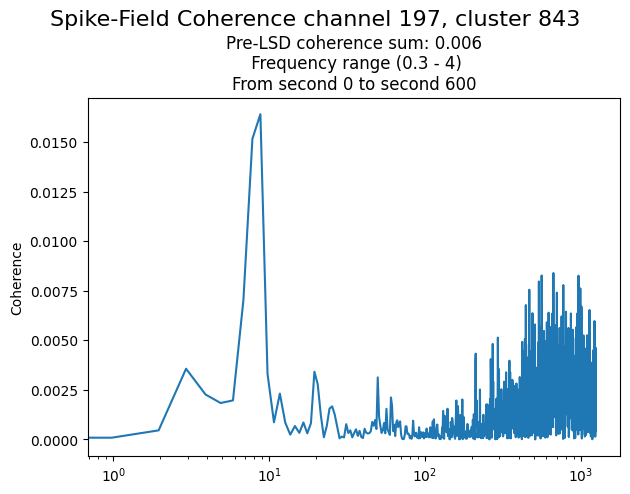

Cluster 845
[  0.77947931   0.84171263   2.33391235   2.40421234   2.49651232
   2.82321226   2.89134558   2.9572789    3.07407888   3.47981214
   6.22257829   6.25614496   6.81767818   6.88437817   6.93374483
   8.5131112   10.54651082  10.92447742  11.02541073  11.34181068
  11.93591056  14.54207675  14.6204434   14.63951006  14.70837672
  14.78294337  14.84884336  14.93937667  15.18720996  15.26100995
  15.32690993  15.39627659  18.10510942  19.19127588  20.84150891
  21.5894421   25.09217478  25.17817477  27.31624104  27.37534103
  28.79754076  29.07294071  29.09740737  29.59734061  30.50607378
  32.67767337  32.97843998  33.38763991  34.42773971  34.54773969
  35.34460621  36.76703928  36.8467726   36.91270592  37.36893917
  37.99797238  38.05887237  38.49837229  38.68757225  38.75050558
  39.1370055   39.43980545  39.48727211  40.17350531  41.14130513
  43.0867381   43.14007142  43.22167141  44.26817121  44.5150045
  49.59543687  49.72413685  49.95293681  51.64813649  53.93216939

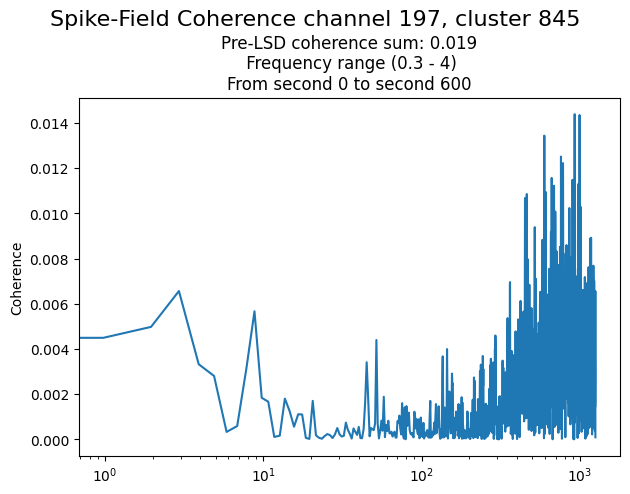

Channel 198
Cluster 850
[1.73146088e-01 1.28661255e+00 1.71294580e+00 ... 5.99399098e+02
 5.99740398e+02 5.99918498e+02]


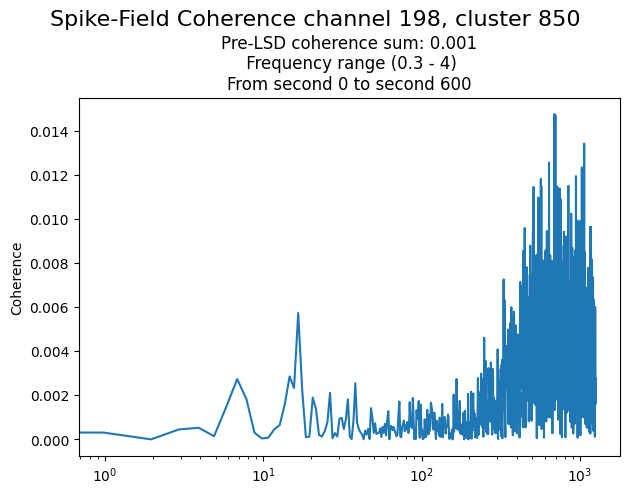

Cluster 1531
[ 43.13523809  43.60140467  44.8456711   44.93427108 151.84204992
 151.99391656 152.05854988 154.08748278 156.63354891 240.62949628
 241.1914628  241.32616277 242.46219582 242.69202909 242.88472905
 243.01992901 243.31916227 244.45922865 244.63752861 245.31052844
 245.67322835 246.1665949  247.15856132 256.83769224 319.87614241
 323.35547479 323.43687477 323.56970806 323.67234137 323.97587462
 324.11850791 324.26927454 324.38920784 324.47107448 325.05937432
 325.40927423 325.71074081 325.80667412 347.81696807 364.07559688
 364.08549687 367.68886253 369.15189545 369.33922873 373.50739423
 375.65239363 385.5421575  385.71389079 385.91212407 386.16289066
 386.29112396 386.92529045 388.0154568  388.18225676 388.33395671
 388.42549002 388.65992329 388.80785658 389.15865648 389.51308971
 389.72602299 389.91452293 390.55762275 391.11212259 391.42032251
 391.76845574 391.87812238 392.38512223 392.79598878 393.04465538
 393.22538866 393.62505522 394.07492176 396.48805441 398.079753

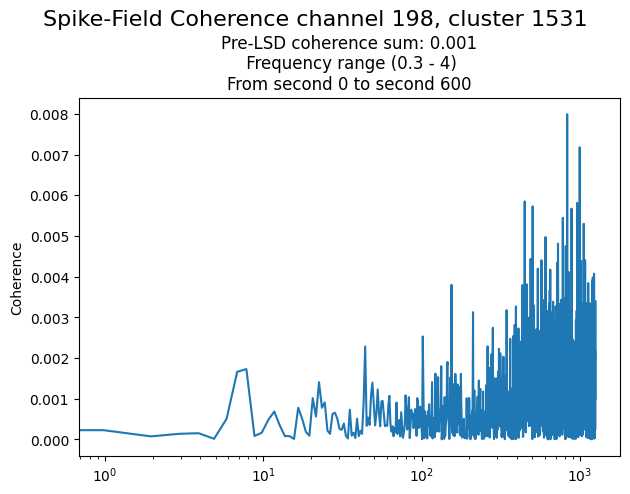

Channel 199
Channel 200
Channel 201
Channel 202
Channel 203
Channel 204
Channel 205
Cluster 878
[189.69260828 220.18306789 221.61476754 221.87503415 222.493934
 230.80849865 236.19583068 239.15042997 239.26429661 239.7338965
 240.44422965 240.54022963 240.7815629  241.98589594 242.66319577
 246.20852822 247.41472792 253.41719309 254.01765961 254.96655937
 255.34709261 256.00935911 256.18865907 256.69239227 263.66629051
 263.86699046 272.20972166 272.89938815 281.48111927 283.31358546
 286.62858459 288.58941741 290.10085034 290.32948362 294.36858255
 317.681943   373.93192744 428.76897857 428.78644523 428.92037853
 448.66907291 473.82889913 474.46316562 475.33126537 475.90156521
 476.06383183 479.31833091 479.53609752 480.18709733 480.55419723
 481.7547969  482.52729668 483.6536297  483.85002964 484.76349605
 485.03449598 485.61312915 486.160129   487.02139542 487.53992861
 488.06009513 488.59859498 489.04562819 489.19216148 491.30922755
 491.93216071 495.17409314 495.98429291 496.97289

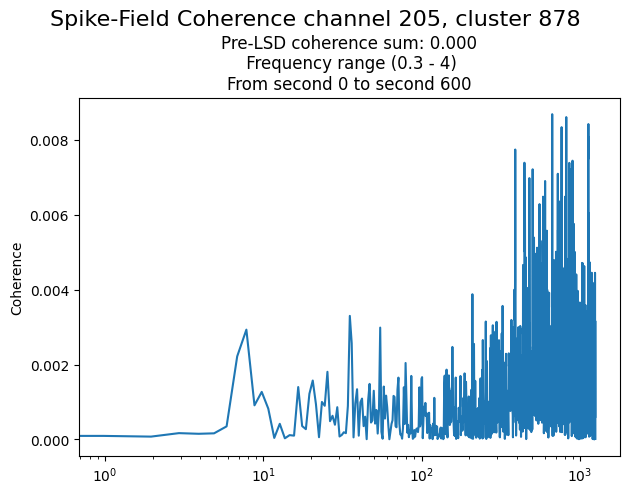

Channel 206
Channel 207
Channel 208
Channel 209
Channel 210
Channel 211
Cluster 896
[1.70812755e-01 3.74979383e-01 4.48879370e-01 ... 5.99723232e+02
 5.99787832e+02 5.99983831e+02]


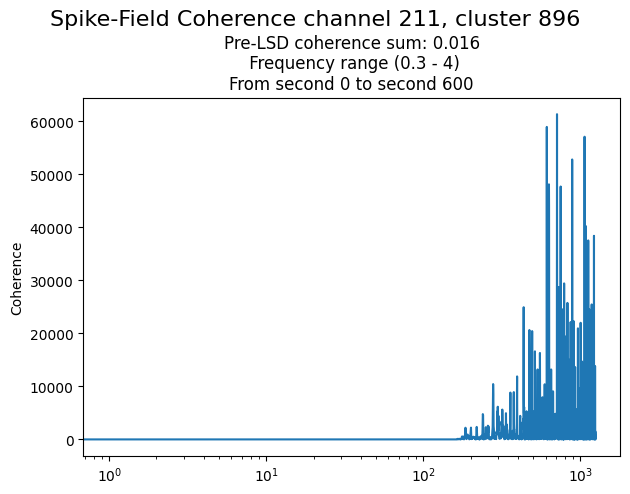

Channel 212
Channel 213
Cluster 912
[1.83912752e-01 5.88279344e-01 7.31712650e-01 ... 5.99251065e+02
 5.99446232e+02 5.99716532e+02]


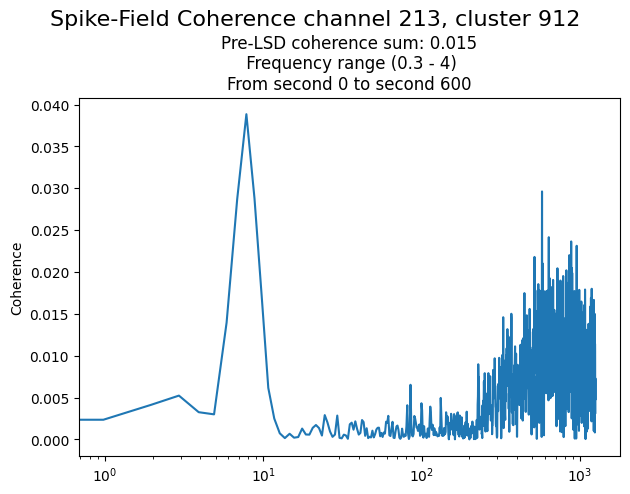

Channel 214
Channel 215
Channel 216
Channel 217
Channel 218
Channel 219
Channel 220
Channel 221
Channel 222
Channel 223
Cluster 949
[1.28579429e-01 1.62112756e-01 4.29012707e-01 ... 5.99791132e+02
 5.99868065e+02 5.99989665e+02]


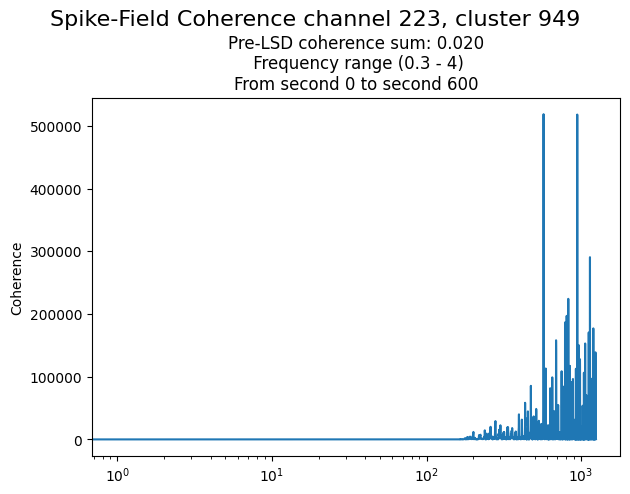

Channel 224
Channel 225
Channel 226
Cluster 965
[  0.99984593   1.0033126    1.16531257 ... 599.51029825 599.98359813
 599.98703146]


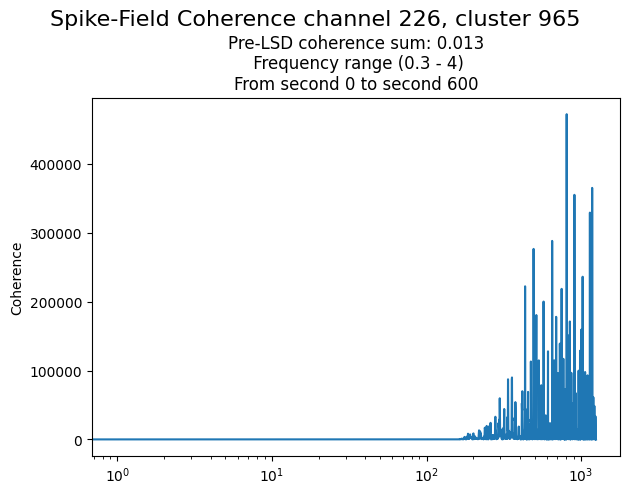

Channel 227
Channel 228
Channel 229
Channel 230
Channel 231
Cluster 974
[1.35379428e-01 2.69546070e-01 2.83746067e-01 ... 5.99737398e+02
 5.99762732e+02 5.99984031e+02]


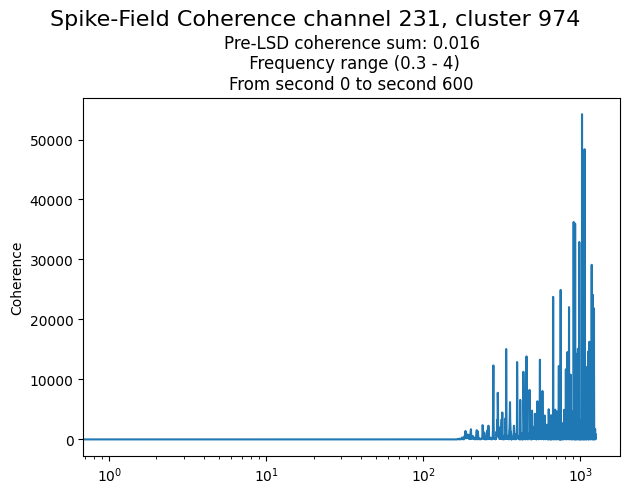

Channel 232
Channel 233
Channel 234
Cluster 990
[ 32.12997347  33.13420662  42.15277161  43.38583804  43.97907126
  44.22737122  65.7091005   69.06646652  74.32279885  85.80816331
  93.91786173  96.23882794  98.72892746 106.19269264 107.86289231
 108.60549216 112.64665802 112.95269129 115.05889087 115.61595742
 116.05125734 116.35985727 118.14185692 119.33085668 120.03892321
 120.87505637 121.07245633 122.59852268 125.93328866 126.57532186
 134.27728695 139.06915263 157.50198206 159.02528173 159.62434827
 161.02191464 163.05644753 163.55964741 164.20981394 167.39124658
 167.49997988 168.07907976 171.83721227 172.80371206 173.36381193
 173.37201193 174.17181176 174.8947116  176.82967784 179.19017732
 180.40557705 185.73344251 187.74470872 188.20200862 190.42364145
 192.67087428 195.82820689 197.09130661 202.63790533 203.51743846
 204.37107159 209.99540361 213.92450269 218.65530158 218.91690152
 219.79130131 220.17656789 220.5516678  220.80083441 221.27410096
 223.04683386 223.74430036 2

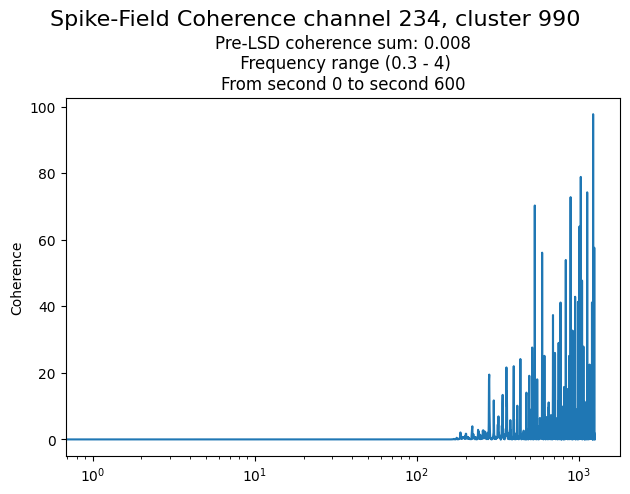

Channel 235
Channel 236
Channel 237
Channel 238
Channel 239
Channel 240
Channel 241
Cluster 1014
[  1.21177923   2.01824574   2.02084574 ... 599.71086486 599.72903153
 599.95049813]


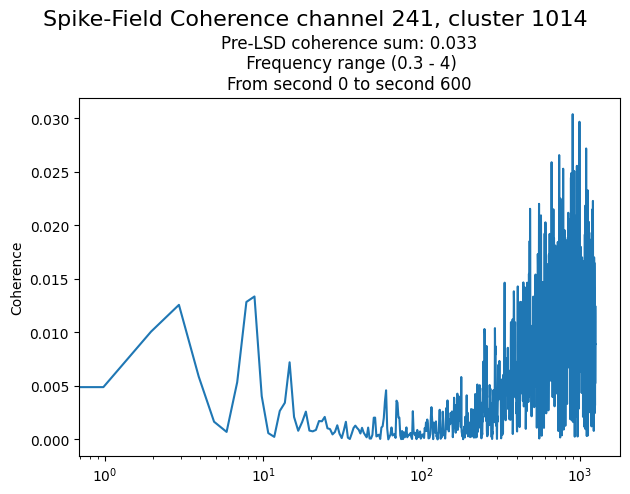

Channel 242
Channel 243
Channel 244
Channel 245
Channel 246
Channel 247
Channel 248
Cluster 1048
[  2.50684565   8.31187791  22.78544188  39.99307201  44.03883792
  44.26013788  65.88916713  66.07370043  83.88233035  91.11756227
 100.68619374 104.62422629 116.91745716 117.15825712 117.76872366
 140.44395234 141.20958551 148.45581731 149.35858378 149.37991711
 172.86214538 179.18324399 183.98187624 189.82104159 192.62610762
 195.13294038 215.425269   220.06716792 226.80879962 229.03056575
 240.21049638 240.97406286 240.98636285 241.37519609 243.68786218
 265.86688995 271.54092183 298.08258158 304.77374646 313.87817735
 317.86187628 322.27694175 322.59304167 323.00820822 323.06587487
 326.65360722 326.81187384 344.79740224 350.73700059 351.06286717
 353.15739992 356.04329912 360.49289788 361.84423084 368.88679553
 368.9699955  369.00072883 369.74352862 377.76869303 377.96782631
 380.67892555 380.88625882 380.92259214 381.36805868 381.76942524
 381.94369186 382.00769184 382.08302515 382.1

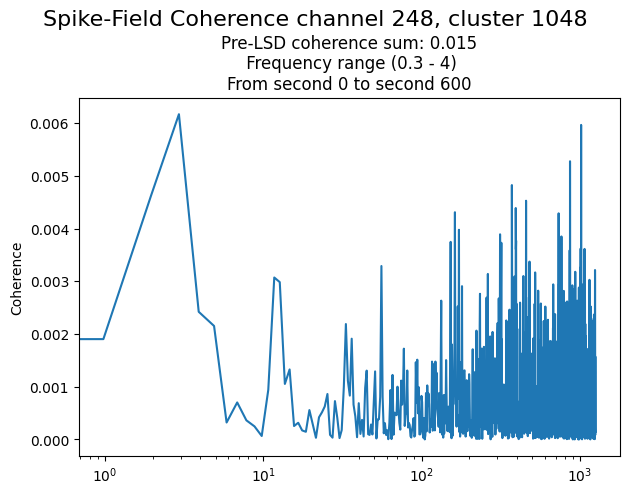

Channel 249
Channel 250
Channel 251
Cluster 1063
[  1.80624578   1.96817909   2.10447906 ... 596.03426583 598.08466529
 599.06796503]


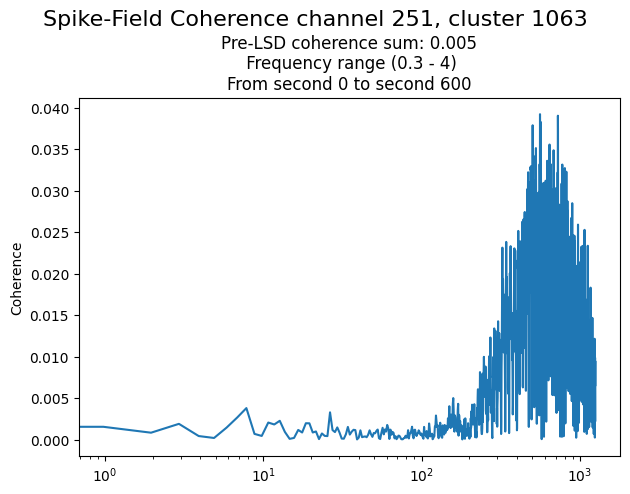

Channel 252
Channel 253
Channel 254
Channel 255
Channel 256
Channel 257
Channel 258
Channel 259
Channel 260
Channel 261
Channel 262
Channel 263
Channel 264
Channel 265
Cluster 1110
[  2.01781241   4.56014527   5.2826118  ... 593.96409971 597.0324989
 597.99296531]


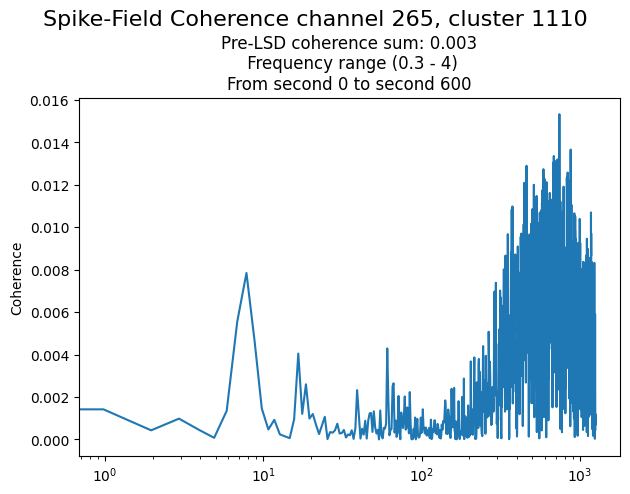

Channel 266
Channel 267
Channel 268
Channel 269
Channel 270
Channel 271
Channel 272
Channel 273
Channel 274
Channel 275
Channel 276
Channel 277
Channel 278
Channel 279
Channel 280
Channel 281
Channel 282
Channel 283
Channel 284
Channel 285
Channel 286
Channel 287
Channel 288
Channel 289
Cluster 1202
[  2.447979     2.71487895   2.76164561 ... 598.74293178 599.3385983
 599.67476487]


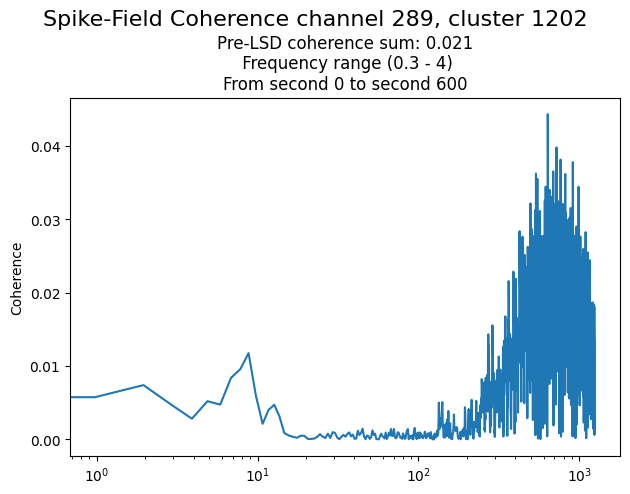

Channel 290
Channel 291
Channel 292
Channel 293
Channel 294
Channel 295
Channel 296
Channel 297
Cluster 1232
[1.61346090e-01 1.93779417e-01 4.55112702e-01 ... 5.99540832e+02
 5.99809898e+02 5.99962898e+02]


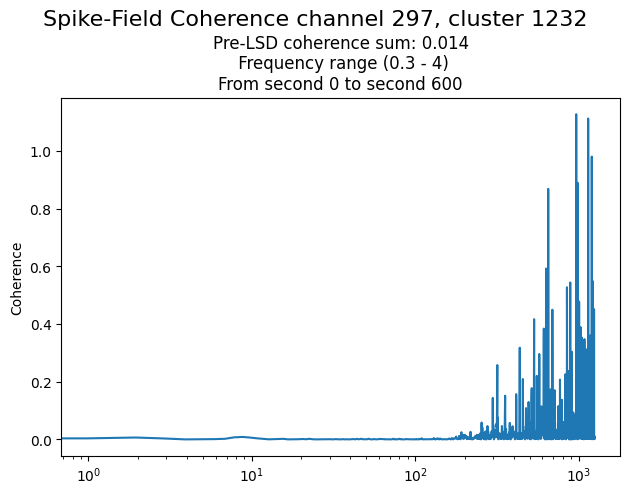

Channel 298
Channel 299
Cluster 1238
[  2.23481237   2.30544569   2.442279   ... 598.66239847 598.69546513
 599.25016498]


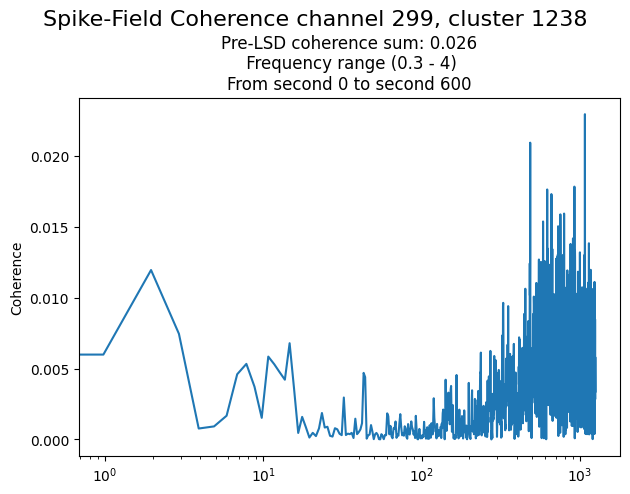

Channel 300
Channel 301
Channel 302
Cluster 1257
[  0.64681267   2.29661236   2.48641232 ... 596.68276566 596.84913228
 599.29223164]


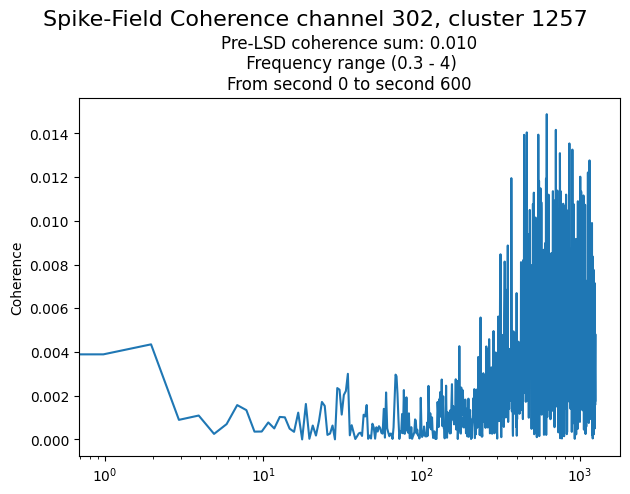

Channel 303
Cluster 1258
[ 16.777243    41.18270512  41.20060512  41.21517178  41.23040511
  41.24847178  41.27017177  41.3018051   74.0692989  102.72176
 102.72756    102.73486    102.75322666 102.76459332 117.31525708
 131.73828747 220.42780116 241.29069611 241.30966277 241.33356277
 241.41069608 241.5884627  241.60842936 241.62442936 241.63086269
 241.79452932 241.80146265 241.91892929 242.00409593 242.11116257
 242.12032924 242.1323959  242.60179578 242.61899578 242.63042911
 242.88726238 242.89876238 242.90489571 243.03809568 243.13959565
 243.14636231 243.3481956  243.37982892 243.38599559 243.49356223
 243.49886223 243.54062888 243.54509555 243.56969554 243.57616221
 243.69312885 243.69816218 243.71096217 244.16462873 244.18026206
 244.18746206 244.48946198 244.49766198 244.58806196 244.59352862
 244.94536187 244.95486186 244.96232853 245.00946185 245.01799518
 245.0758285  245.0813285  245.2136618  245.21969513 247.00439469
 250.77899375 256.14855908 256.25995905 260.02129144 2

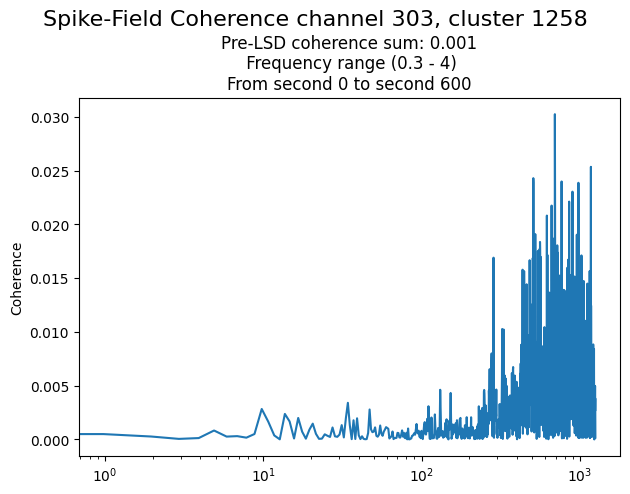

Channel 304
Channel 305
Channel 306
Channel 307
Channel 308
Channel 309
Cluster 1282
[ 11.24904403  17.40484288  18.08237609  39.43470545  39.47177211
  39.49913877  41.23973844  41.32717176  41.42090508  41.46380507
  42.92440479  42.99077145  43.02110478  43.11643809  43.68610465
  45.13700438  45.68330428  45.98187089  46.05800421  46.09343753
  57.34343542  59.3736017   60.16730156  72.55783252  72.84043247
  74.04106558  76.55433176  89.03689601  93.58782846  98.86666076
 116.52139058 117.31929042 117.69745701 119.49415665 133.43485379
 140.85458559 142.05718533 149.75711703 149.82851702 151.64974997
 153.90084949 171.97561224 173.29604528 177.22181109 180.30667708
 185.27977595 185.35830927 185.38717593 185.59960921 185.8125425
 187.19904218 198.7628729  200.21513923 201.07553903 213.28116951
 216.13386884 218.39543497 229.05463241 237.83389696 238.09063023
 238.75153007 238.78103006 238.82319672 239.10686331 239.8687298
 241.09856282 241.16566281 241.95779594 242.92856237 243.57

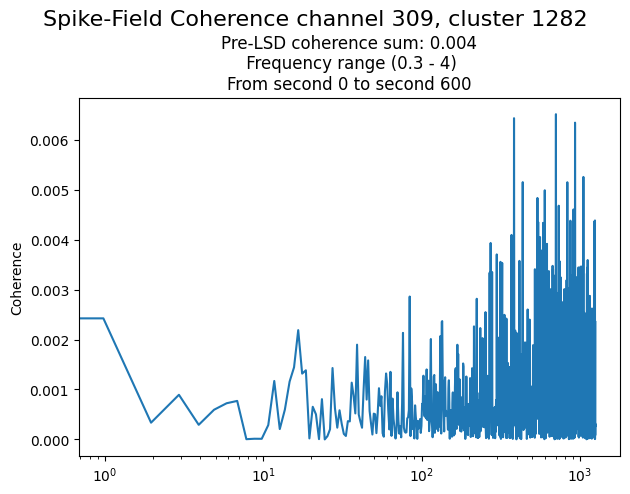

Channel 310
Channel 311
Channel 312
Channel 313
Cluster 1291
[5.66379348e-01 6.90712658e-01 1.03847926e+00 ... 5.97583999e+02
 5.97732265e+02 5.99769365e+02]


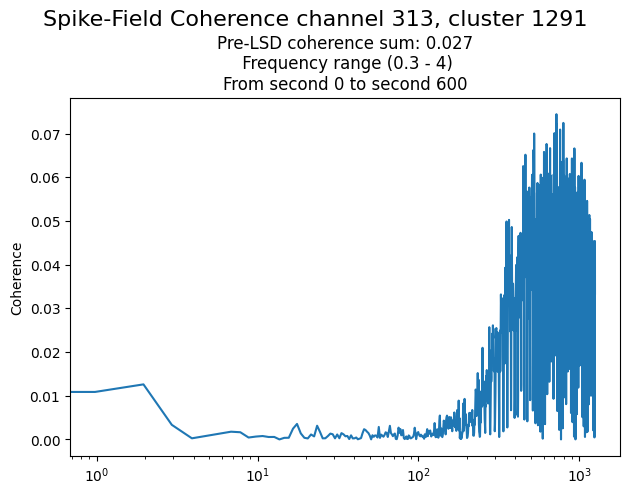

Channel 314
Channel 315
Cluster 1303
[2.50794484e-02 3.98794457e-02 1.22612764e-01 ... 5.99930665e+02
 5.99953398e+02 5.99996198e+02]


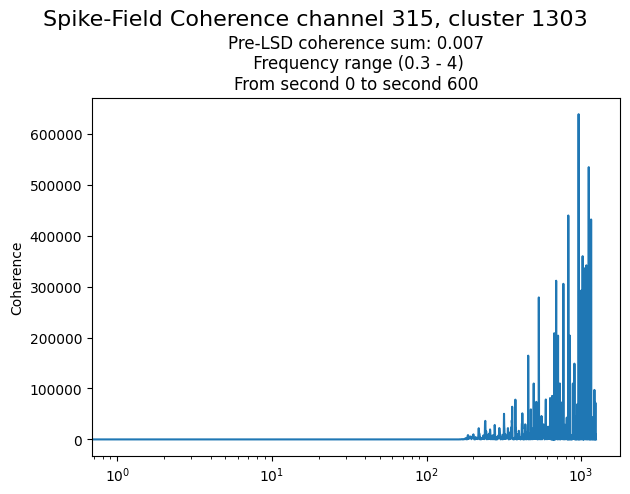

Channel 316
Channel 317
Channel 318
Channel 319
Channel 320
Channel 321
Channel 322
Channel 323
Channel 324
Channel 325
Cluster 1346
[ 15.39000992  48.46400375  48.7488037   48.86560368  49.10320363
  49.29403693  90.53479572  91.04056229  91.08456228  91.55282885
 121.65542287 121.95968948 126.93492179 145.00938471 166.6712134
 198.93177286 208.0231374  212.71640297 217.44906853 218.52660161
 220.26173454 220.45156782 220.57440113 220.75893442 223.82463367
 224.31650022 224.60103349 226.80276629 226.96899958 227.14959954
 227.26426618 227.36669949 227.47639946 227.60143276 234.0550312
 235.12799761 236.11236404 236.33146399 236.99573049 237.21183044
 237.29099709 237.37366373 237.48879704 237.74299698 237.89763027
 239.1573633  239.23102995 240.99732952 241.36626276 241.49249606
 241.5864627  241.66559602 252.9640932  253.61302637 255.88549247
 255.96872579 257.0010922  271.69885512 279.64598642 289.31971721
 298.35808151 298.66421476 298.82994805 305.12304637 305.54587959
 308.184312

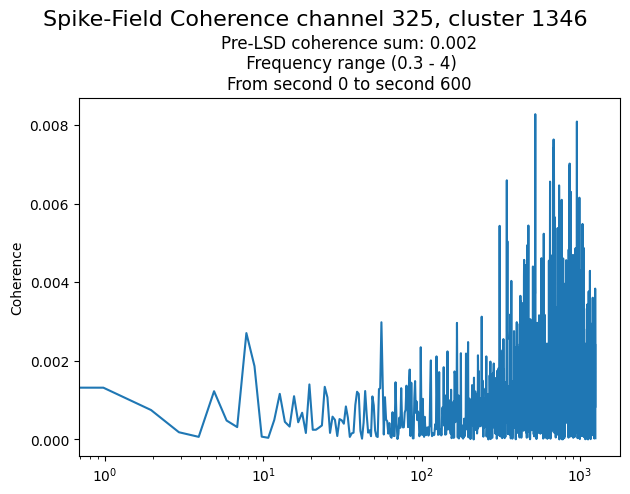

Channel 326
Channel 327
Channel 328
Channel 329
Cluster 1362
[1.57746090e-01 3.93246047e-01 6.25079337e-01 ... 5.99648465e+02
 5.99820065e+02 5.99872031e+02]


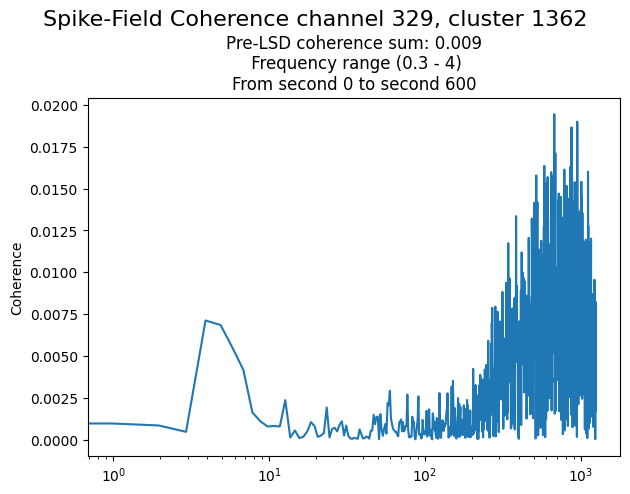

Cluster 1367
[  9.32441105  10.80424411  10.82791077 ... 599.41036494 599.61379822
 599.90559815]


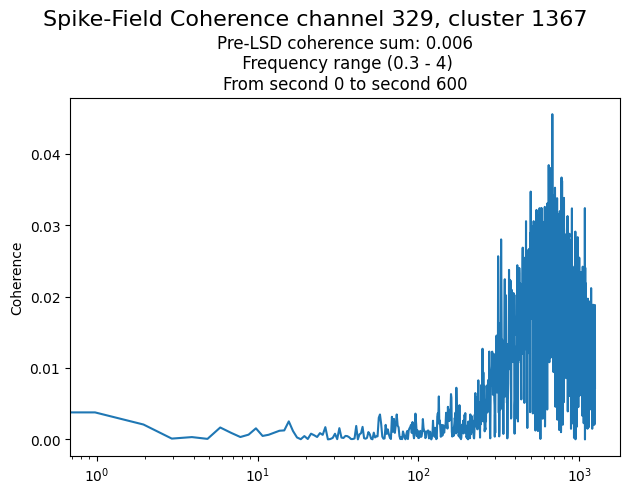

Channel 330
Channel 331
Channel 332
Channel 333
Cluster 1377
[  8.75011116   9.32451105  10.80434411 ... 599.41046494 599.61389822
 599.90569815]


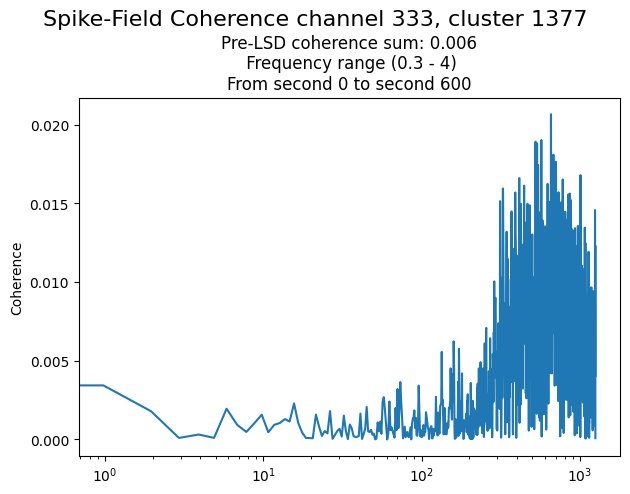

Channel 334
Channel 335
Channel 336
Cluster 1385
[1.74812754e-01 2.43046075e-01 3.90212714e-01 ... 5.99820332e+02
 5.99898431e+02 5.99973131e+02]


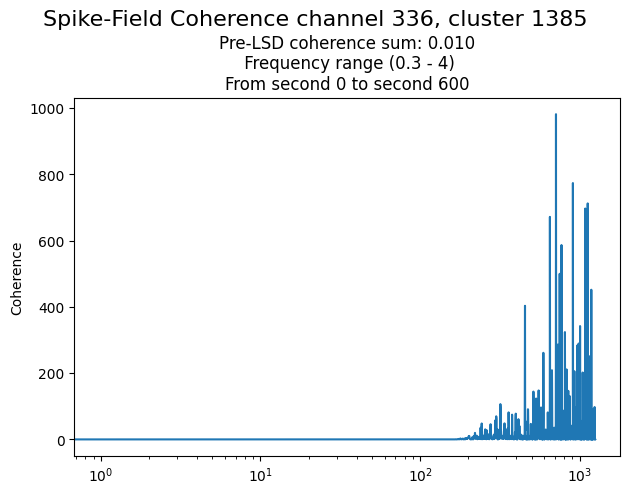

Cluster 1389
[  0.9809126    2.8078456    3.03371222   3.43524548   4.01417871
   7.6448447   10.06204425  10.81984411  10.8540441   14.50657675
  14.57294341  14.59241007  14.68724339  14.69841005  14.71841005
  14.74517671  14.77974337  14.79521003  14.8089767   14.83127669
  14.84861002  15.21637662  15.25650995  15.27364328  15.30330994
  15.6757432   15.78414318  15.81464318  16.86544298  24.86890816
  26.55314118  26.84564112  27.32487437  31.32067362  33.12060662
  39.05077219  39.38133879  39.51730543  39.75350539  39.95617202
  40.72547187  40.85557185  40.98817183  41.30137177  41.49160506
  42.16593827  42.19813826  42.28863825  42.30150491  42.40177156
  42.54190487  42.62637152  42.66453818  42.81423815  43.04053811
  43.30030472  43.43487137  43.51790468  43.54127135  44.11337124
  44.14330457  44.20003789  44.24110455  44.28060454  44.66670447
  44.75167112  47.80520388  49.64980353  49.68437019  49.71010352
  49.97767014  58.35473523  58.39196856  59.18883507  59.475601

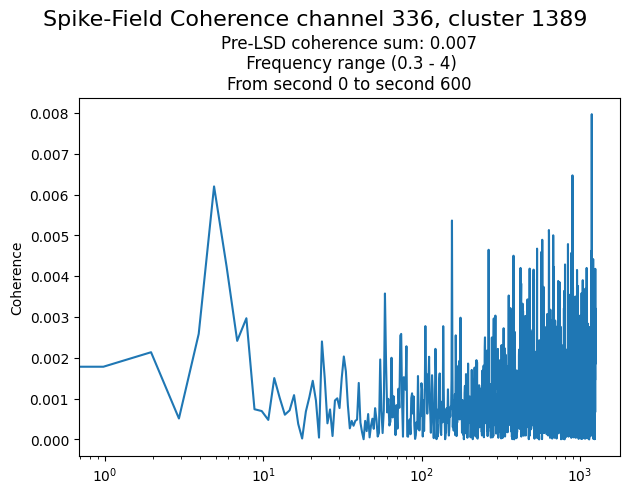

Channel 337
Channel 338
Channel 339
Cluster 1400
[1.59646090e-01 2.16479413e-01 6.02212674e-01 ... 5.99643732e+02
 5.99766698e+02 5.99987998e+02]


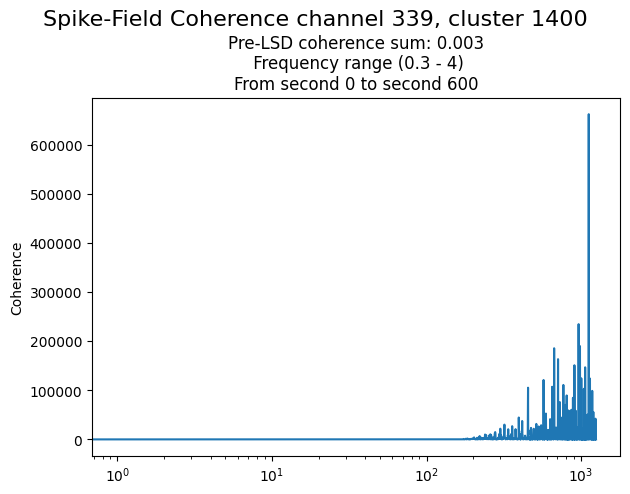

Channel 340
Channel 341
Cluster 1411
[8.40461041e-02 3.32979391e-01 4.54179369e-01 ... 5.96628166e+02
 5.97164532e+02 5.99732932e+02]


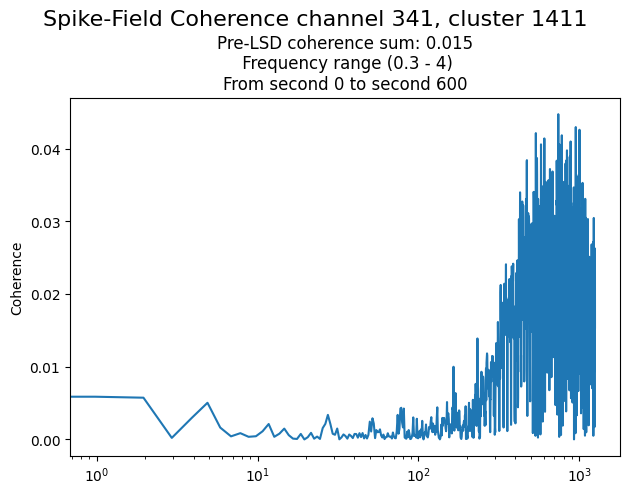

Channel 342
Cluster 1418
[  8.25757792   8.26077792   8.26484458  12.2613105   12.55461045
  12.81194374  12.81464373  13.36847696  13.37327696  13.37687696
  13.3839103   13.96394352  21.9395087   22.07677534  24.52447489
  25.04897479  29.98534054  30.47397378  33.82323983  35.18547291
  43.93050461  48.03290384  50.99183661  50.99486995  51.56313651
  56.44953559  57.89963532  58.11260194  65.35896723  65.68623384
  67.69110012  68.53759996  68.95309988  71.34719942  71.35039942
  72.45683254  72.46286588  72.46653254  77.72986487  77.73246487
  77.82613152  77.83199819  78.59686471  78.68139802  78.80016467
  79.75886448  80.29183105  80.54949766  80.96373092  81.32789751
  81.33226418  83.24066381  83.41446377  83.98126366  84.56993021
  84.77139684  86.28489655  90.77906234  92.09276208  92.16232874
  92.16766207  93.09152855  95.6153614   96.01462799  99.85392724
  99.91026056 100.00589387 100.32439381 100.58406043 100.59166042
 102.25626009 104.26775969 104.30135968 104.3475596

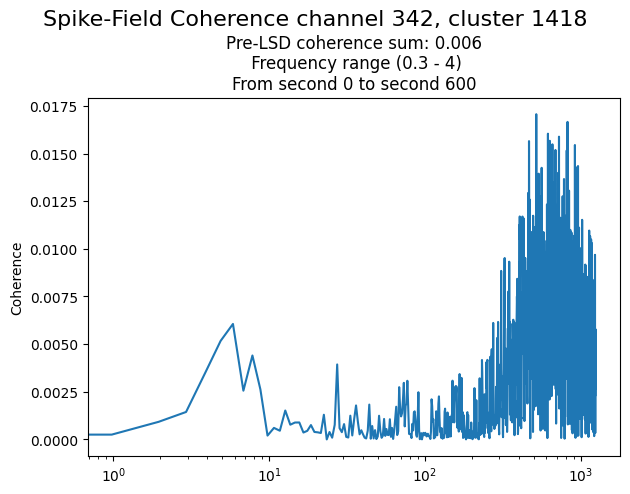

Channel 343
Channel 344
Channel 345
Cluster 1426
[  1.54674583   5.2868118    5.52274509  15.47904324  21.27390883
  22.39657528  24.54367489  25.58860802  26.75434114  26.8177078
  27.27517438  27.52307433  29.76134058  34.88207296  37.87103907
  40.9375385   51.34866988  57.89263532  58.03836862  63.87693418
  72.92526579  75.57353195  80.39589769  80.81076428  80.89866426
  88.96772936  96.75576117 102.79962665 104.14445971 108.05435893
 108.21142557 108.49082551 117.90832363 120.34692314 123.70815579
 123.82948909 124.06258905 131.68785414 139.17355261 144.51585148
 147.35378421 147.65748415 147.83535077 150.33211691 151.6435833
 158.33778188 158.92331509 158.98451508 162.88384756 163.46164744
 164.32671391 164.36218057 164.59844719 164.72811383 165.04108042
 165.47934699 165.65141362 165.76688026 166.69744673 168.26937972
 171.48797901 175.45627814 176.36744461 181.70401009 189.51850832
 191.8232078  192.74887426 196.57724006 197.67523981 198.08233972
 200.92240573 202.74787197 21

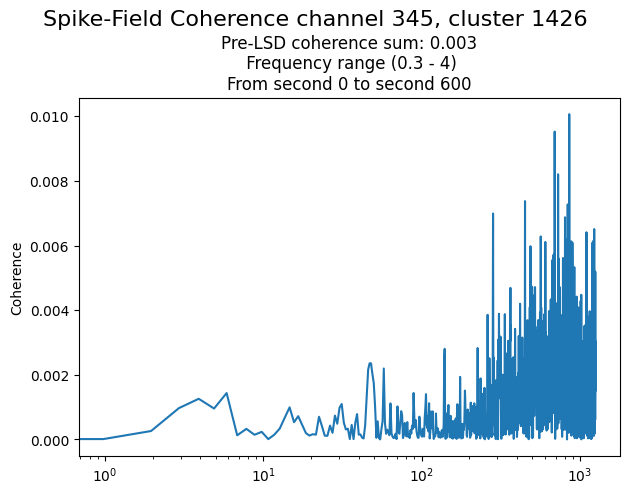

Channel 346
Cluster 1430
[1.84012752e-01 5.17279357e-01 1.24581255e+00 ... 5.99577798e+02
 5.99706298e+02 5.99820898e+02]


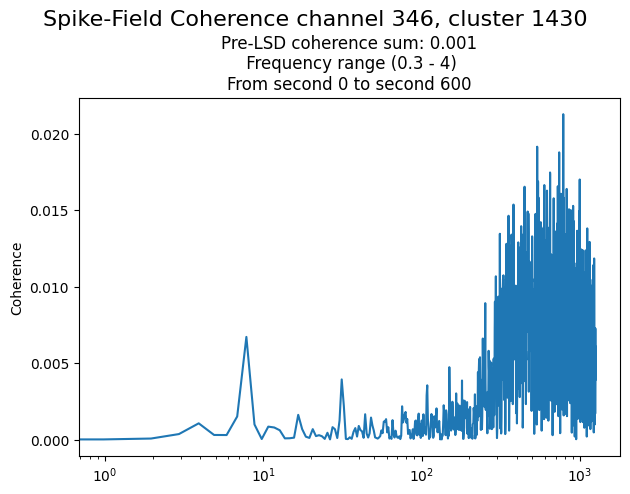

Cluster 1434
[  1.80171245   2.38521234   2.74167894   5.23401181  14.6118434
  16.43857639  16.61700969  23.14064181  23.34727511  23.47400842
  23.82420835  23.90650834  24.07977497  24.22030828  24.57204155
  24.86000816  25.22507476  25.50724137  25.64644135  25.81820798
  25.91067463  25.95477462  26.16814125  26.34234122  26.86480779
  26.9754411   27.04844109  27.15870773  27.44037435  27.99520758
  28.66620745  28.83670742  28.99447406  29.15270736  29.46737397
  29.60487394  29.73714059  31.41150694  31.57854024  31.88984019
  32.1544068   35.80673946  36.15140606  36.58687265  36.70963929
  36.93503925  37.3719725   37.77190576  38.04983904  38.31403899
  39.51583877  40.49277192  42.34243824  53.24563619  57.16853545
  70.43733293  77.44026493  96.68316119 100.74629373 101.01509367
 132.24075403 147.0934176  149.69508371 154.9539826  159.92234821
 160.08751484 160.20091482 160.35604812 160.49928142 168.12744641
 168.25984638 168.29254638 168.53044633 168.85574625 169.7319460

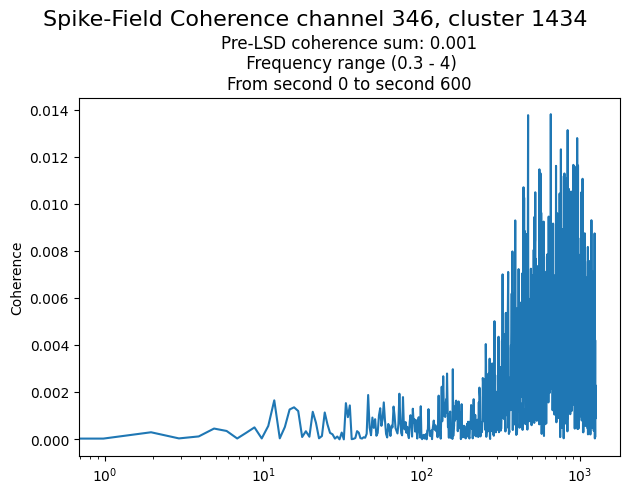

Cluster 1435
[5.26461100e-02 1.06212767e-01 2.85579400e-01 ... 5.99499665e+02
 5.99791998e+02 5.99939065e+02]


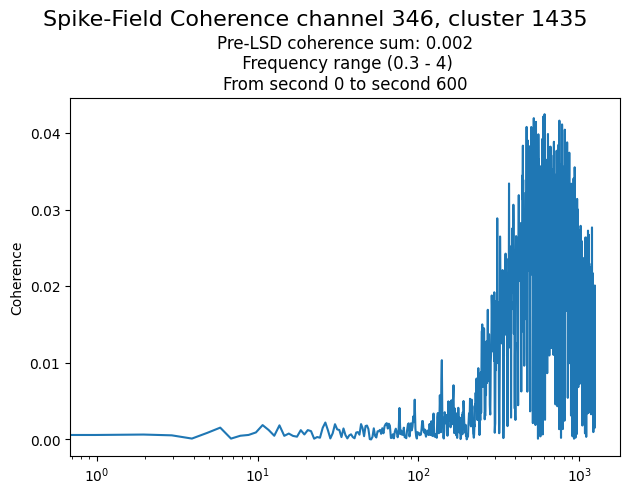

Channel 347
Channel 348
Channel 349
Cluster 1440
[1.32146095e-01 2.07646081e-01 3.21579393e-01 ... 5.99704732e+02
 5.99868531e+02 5.99944631e+02]


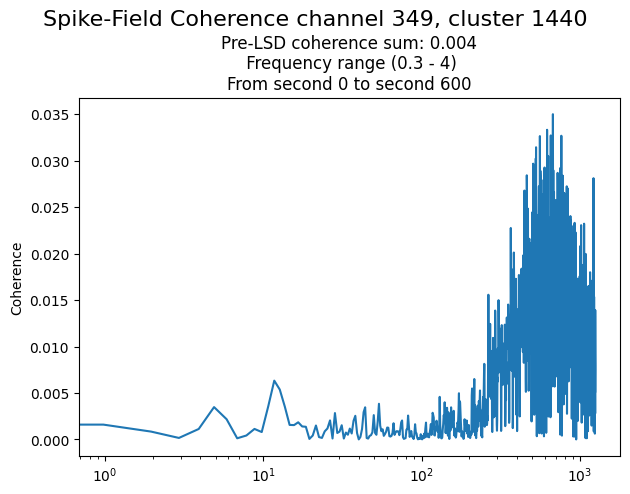

Channel 350
Channel 351
Channel 352
Channel 353
Channel 354
Channel 355
Channel 356
Channel 357
Channel 358
Channel 359
Channel 360
Channel 361
Channel 362
Channel 363
Channel 364
Channel 365
Channel 366
Channel 367
Channel 368
Channel 369
Channel 370
Channel 371
Channel 372
Channel 373
Channel 374
Channel 375
Channel 376
Channel 377
Channel 378
Channel 379
Channel 380
Channel 381
Channel 382
Channel 383


KeyError: 0

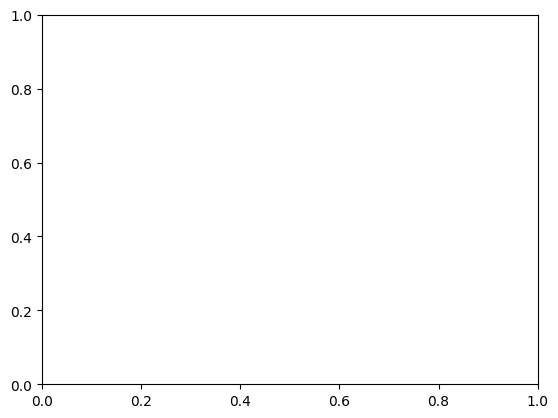

In [30]:
# Define window length and step size (in seconds)
window_length = 600
step_size = 60
session_seconds = sr.shape[0]/sampling_rate
print(f'Session time: {session_seconds} seconds ({(session_seconds/60):.2f} minutes)')
# Calculate the number of windows
num_windows = int(((session_seconds) - window_length) / step_size) + 1

coherences_per_window_per_channel = {}
print (f'Total number of sliding windows: ', num_windows)
# Loop over windows
for i in range(num_windows):
    print (f'Window number {i}')
    seconds_start = i * step_size
    seconds_end = seconds_start + window_length

    t_min = seconds_start * sampling_rate
    t_max = seconds_end * sampling_rate

    # Get the data for the current window
    data_window = sr[t_min:t_max, :-sr.nsync]
    data_window = resample(data_window, int(len(data_window) / 2), axis=0)  # sr becomes 1250!!
    coherences_per_window_per_channel[f'{i}'] = {}

    for ch in range(data.shape[1]):
        coherences_per_window_per_channel[f'{i}'][f'{ch}'] = {}
        print (f'Channel {ch}')
        for cluster_in_channel in clusters['cluster_id'][clusters['channels']==ch]:

            coherences_in_cluster = []
            spike_times = spikes['times'][(spikes['clusters']==cluster_in_channel) & 
                                        (spikes['times']<t_max/sampling_rate) & 
                                        (spikes['times']>t_min/sampling_rate)]#Add condition to get mPFC clusters only
            if (len(spike_times)>100): #Maybe should get rid of this condition???????????
                bw = 0.01   # gaussian kernel bandwidth in seconds
                #SR adequate to downsampled lfp!!!!!!!!!!!!!!!!
                dt = 2 / sampling_rate # time resolution of the firing rate in seconds (should be same as for the LFP data)
                rate_kernel = GaussianKernel(bw*pq.s)
                print (f'Cluster {cluster_in_channel}')
                print(spike_times)

                spike_train_pre = SpikeTrain(spike_times, t_start=t_min/sampling_rate, t_stop=t_max/sampling_rate, units='s')
                firing_rate_pre = instantaneous_rate(spike_train_pre, sampling_period=dt*pq.s, kernel=rate_kernel).squeeze()
                # bins, spike_train = np.histogram(spike_times, bins = np.arange(t_min / sampling_rate, t_max / sampling_rate, (1/sampling_rate)))
                frequencies, coherence_values = coherence(data[:, ch], firing_rate_pre, fs=sampling_rate, nperseg = 2560)
                i0, i1 = frequencies.searchsorted([bottom_freq, top_freq])

                fig, axs = plt.subplots(1,1)

                # print('coherence_values[i0:i1].mean: ', coherence_values[i0:i1].mean())
                # print('coherence_values[i0:i1].sum: ', coherence_values[i0:i1].sum())
                # print (frequencies)    
                # print (frequencies.shape)    
                axs.semilogx(frequencies, coherence_values)
                axs.set_title(f'Pre-LSD coherence sum: {coherence_values[i0:i1].sum():.3f}\n Frequency range ({bottom_freq} - {top_freq})\nFrom second {seconds_start} to second {seconds_start + time_window}')
                axs.set_ylabel('Coherence')
                plt.tight_layout()
                fig.suptitle(f'Spike-Field Coherence channel {ch}, cluster {cluster_in_channel}', fontsize=16, y=1.02)
                plt.show()

                coherences_in_cluster.append(coherence_values[i0:i1].sum())
                coherences_per_window_per_channel[f'{i}'][f'{ch}'][f'{cluster_in_channel}'] = [coherences_in_cluster]

        # conditions =  ['Pre-LSD'] * len(all_coherence_values)
        # sum_coherence = [*all_coherence_values]
        # # coherences_per_channel_instantaneous [ch] = [all_coherence_values]
        # plt.scatter(conditions, sum_coherence)
        # plt.show()

    # create a scatter plot
    fig, ax = plt.subplots()
    coherences = coherences_per_window_per_channel[f'{i}']
    # create 'pre-LSD' scatter points at x=1 and 'post-LSD' scatter points at x=2
    pre = []
    post = []

    for ch in coherences.keys():
        for cluster_number in range(len(coherences[ch][0])):
            if len(coherences[ch][0]) > 0:
                ax.scatter(1, coherences[ch][0][cluster_number], color = 'grey') # pre-LSD
                pre.append(coherences[ch][0][cluster_number])
                ax.scatter(2, coherences[ch][1][cluster_number], color = 'grey') # post-LSD
                post.append(coherences[ch][1][cluster_number])
                ax.plot([1, 2], [coherences[ch][0][cluster_number], coherences[ch][1][cluster_number]], color='grey', linewidth=0.2)
    ax.scatter(1, np.mean(pre), color = 'red')
    ax.scatter(2, np.mean(post), color = 'red')
    ax.plot([1, 2], [np.mean(pre), np.mean(post)], color='red', linewidth=0.5)
    # adding title and labels
    plt.title('Coherences per Channel')
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['pre-LSD', 'post-LSD'])
    plt.ylabel('Coherence')

    # display plot
    plt.show()

In [32]:
coherences.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', 